In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

from generation.config import DATA_DIR
from generation.dataset.data_utils import get_detector_event_df, get_detector_event_signal, get_detector_event_df_path
from generation.dataset.data_utils import generate_one_signal

In [2]:
import torch

In [3]:
# !pip install ../..

In [4]:
_DETECTOR = 0
_EVENTS_NUM = 200


# detector_signals = np.array([get_detector_event_signal(_DETECTOR, event) 
#                     for event in range(_EVENTS_NUM)])

In [5]:
# import multiprocessing as mp

# COEF = 100

# def process_event(event_df, coef=COEF):
#     event_signals = []
#     for _ in range(coef):
#         event_signal = generate_one_signal(event_df, frac=0.8)
#         event_signals.append(event_signal)
#     return event_signals


# event_dfs = np.array([get_detector_event_df(_DETECTOR, event) 
#                     for event in range(_EVENTS_NUM)])
# with mp.Pool(32) as pool:
#     signals = pool.map(process_event, event_dfs)

# signals = np.reshape(signals, (-1, np.array(signals).shape[-1]))

# with open(f"{DATA_DIR}detector_{_DETECTOR}_signals.npy", 'wb') as signals_file:
#     np.save(signals_file, signals)

In [6]:
with open(f"{DATA_DIR}detector_{_DETECTOR}_signals.npy", 'rb') as signals_file:
    signals = np.load(signals_file)

### Data preparation

In [7]:
from sklearn.preprocessing import MinMaxScaler

from generation.dataset.dataset_pytorch import SignalsDataset

In [8]:
def unify_shape(data):
    min_values = np.min(data, axis=1)
    max_values = np.max(data, axis=1)
    data = (data  - min_values[:, None]) / (max_values - min_values)[:, None]
    return data


def get_dataset(data):
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    dataset = SignalsDataset(data)
    return dataset, scaler, data


origin_data = signals.copy()
data = unify_shape(origin_data)
data = data[~np.isnan(data).any(axis=1)]
origin_noises = data - np.mean(data, axis=0)
noises_dataset, noises_scaler, noises = get_dataset(origin_noises)

/home/pafakanov/data/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


## Model

In [9]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from generation.train.wgan import run_train, generate_new_signal

wandb: Currently logged in as: whitera2bit (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.10.1
wandb: Run data is saved locally in wandb/run-20200921_100007-19zme48z
wandb: Syncing run olive-river-22


In [10]:
SAMPLE_SIZE = 2048

# Train params
NUM_EPOCHS = 10000
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
LATENT_DIM = 16
PRINT_EACH = 5
VERBOSE = 1
HIDDEN_DIM = 25
SEQ_LEN = 20
NO_SAVE = True
CPU = False

In [11]:
class Generator(nn.Module):
    def __init__(self, x_dim, latent_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM, seq_len=SEQ_LEN):
        super(Generator, self).__init__()
        self.x_dim = x_dim
        self.hidden_dim = HIDDEN_DIM
        self.seq_len = SEQ_LEN
        
        self.lstm = nn.LSTM(self.hidden_dim, self.hidden_dim, \
                            num_layers=1, batch_first=True).cuda()
        self.fc = nn.Linear(self.hidden_dim * self.seq_len, x_dim)
        
    def forward(self, h_0, c_0):
        batch_size = h_0.shape[1]
        inputs = Variable(torch.zeros(BATCH_SIZE, self.seq_len, self.hidden_dim))
        inputs = inputs.cuda() ## Fix
        
        out, _ = self.lstm(inputs, (h_0, c_0))
        out = out.reshape(batch_size, -1)
        out = self.fc(out)

        return torch.sigmoid(out)

In [12]:
class Discriminator(nn.Module):
    def __init__(self, x_dim):
        super(Discriminator, self).__init__()
        self.x_dim = x_dim
        self.in_channels = 16
        
        self.relu = nn.LeakyReLU(0.2)

        self.fc_final = nn.Linear(self.x_dim // self.in_channels - 2, 1)

        self.conv1 = nn.Conv1d(self.in_channels, 1, 3)
#         self.conv2 = nn.Conv1d(8, 4, 3)
#         self.conv3 = nn.Conv1d(4, 1, 3)

    def forward(self, signal, debug=False):
        def _debug(out):
            if debug:
                print(out.shape)

        _debug(signal)
        out = signal.view(signal.shape[0], self.in_channels, self.x_dim // self.in_channels)
        _debug(out)
        out = self.relu(self.conv1(out))
        _debug(out)
#         out = self.relu(self.conv2(out))
#         _debug(out)
#         out = self.relu(self.conv3(out))
#         _debug(out)
        out = out.squeeze(1)
#         _debug(out)
        out = self.fc_final(out)
        _debug(out)


        return out

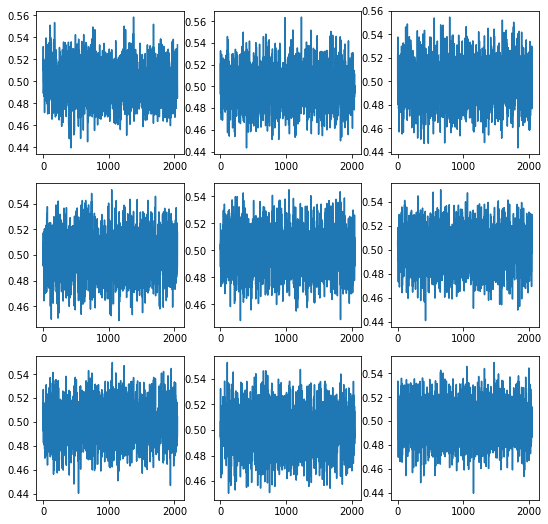

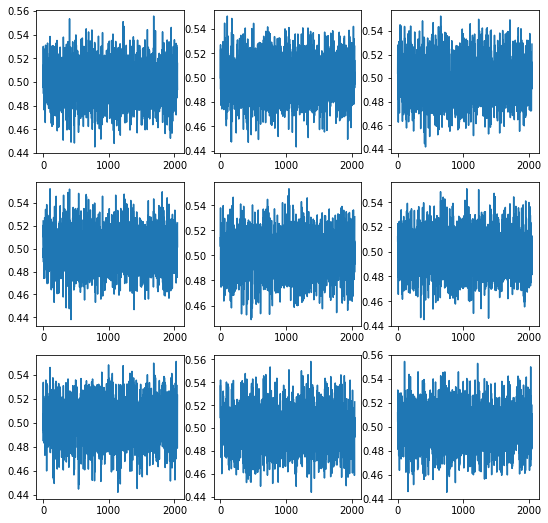

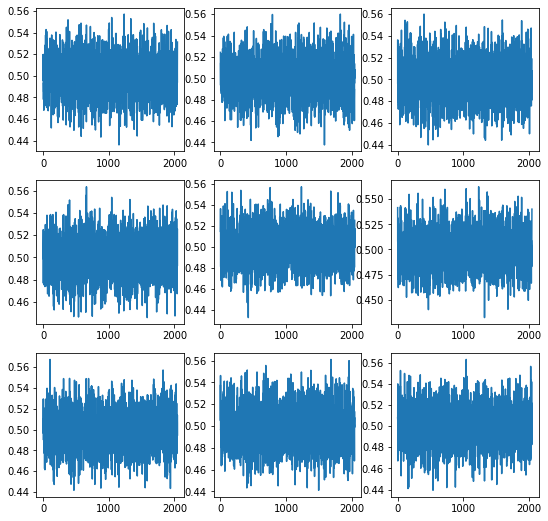

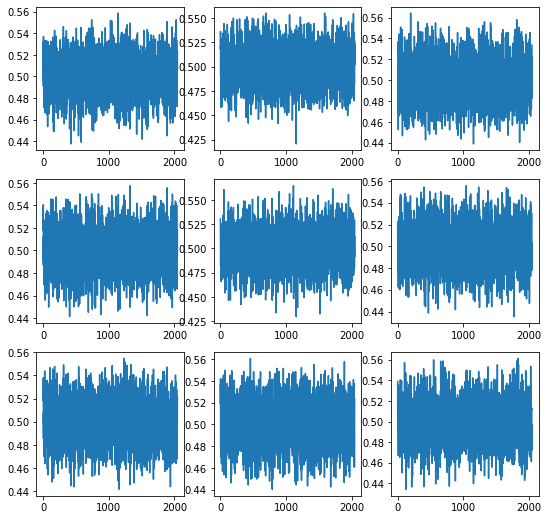

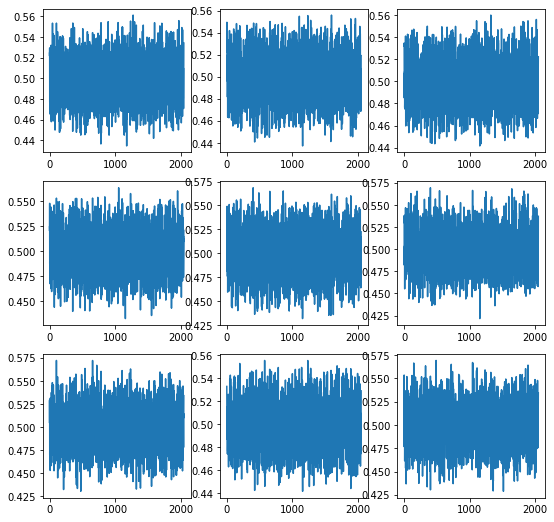

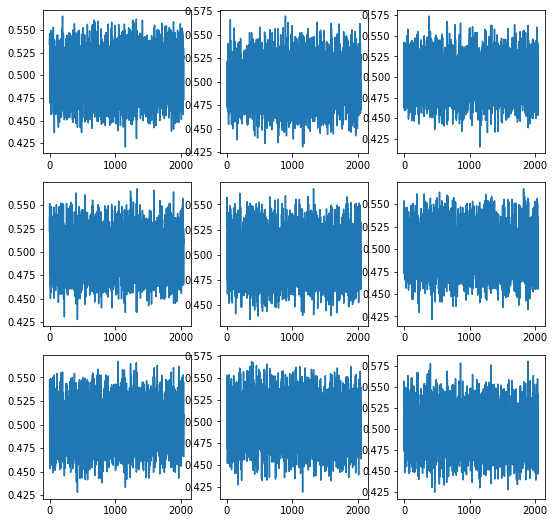

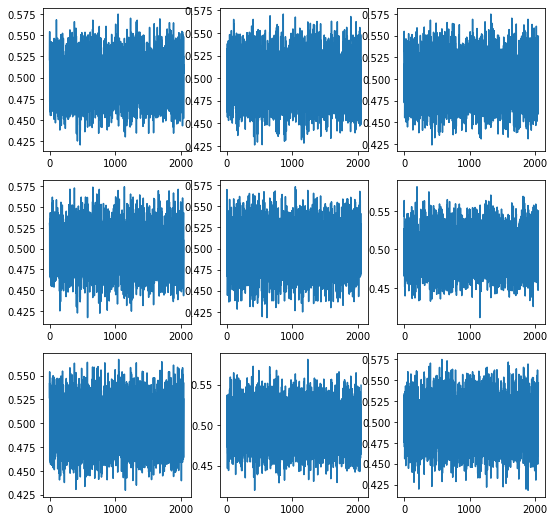

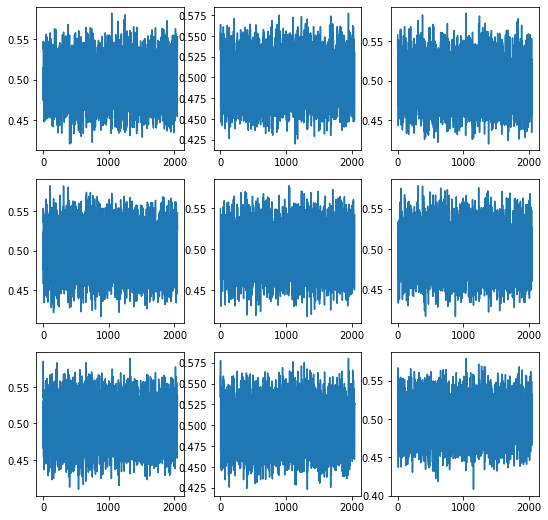

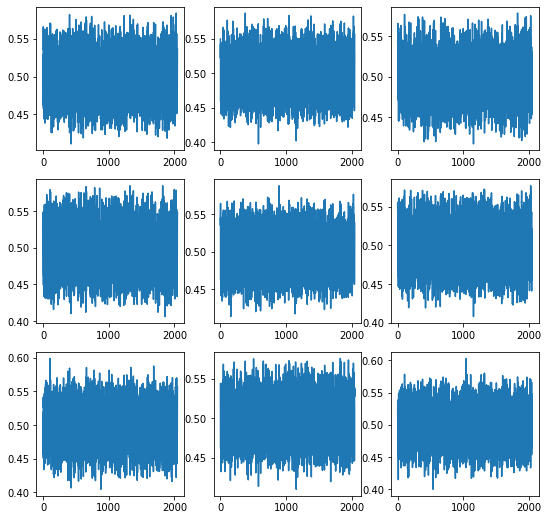

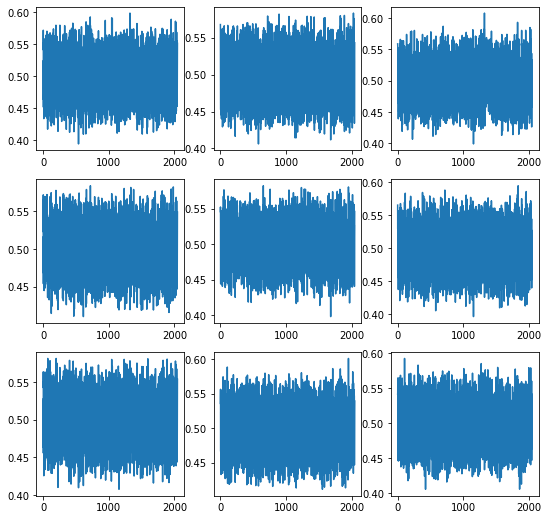

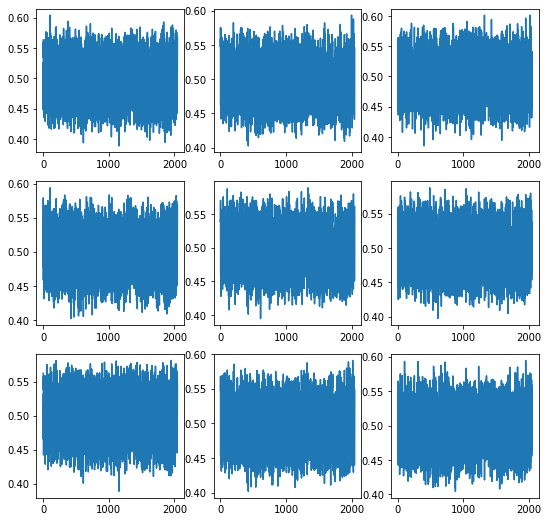

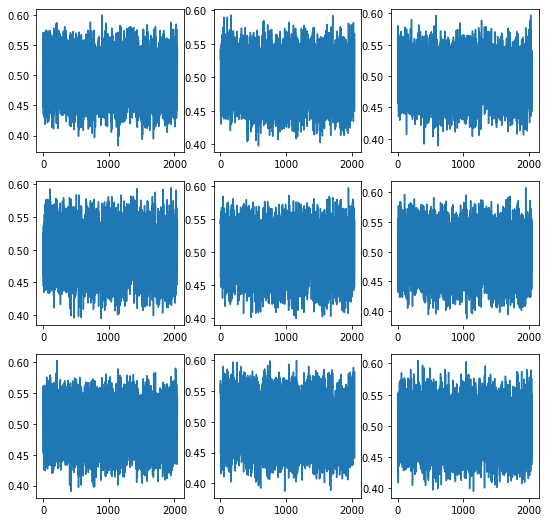

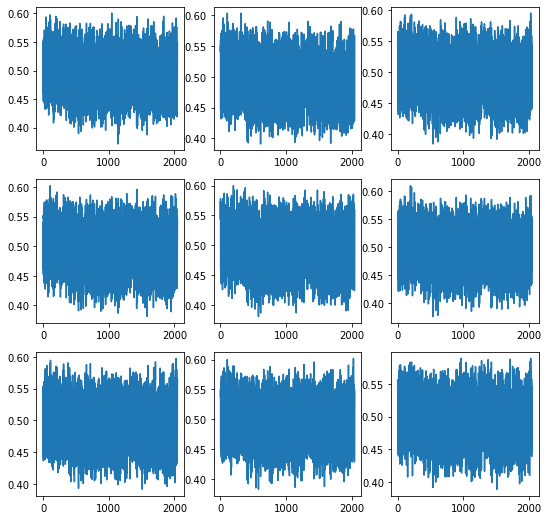

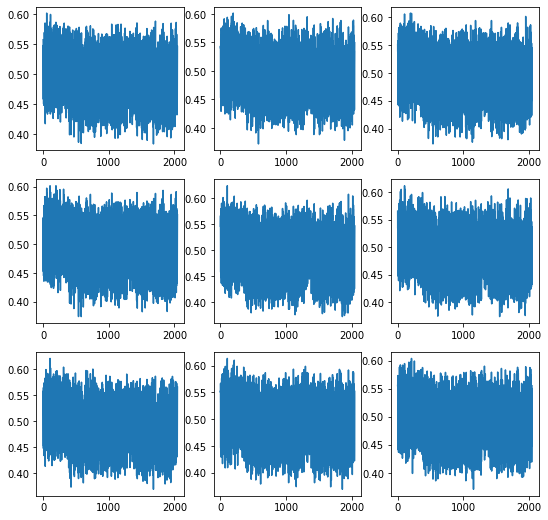

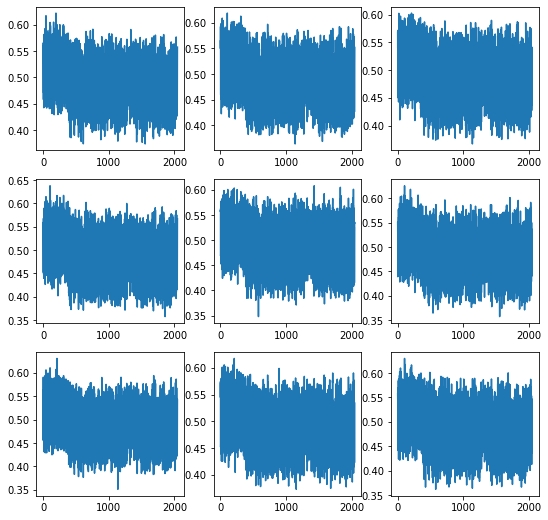

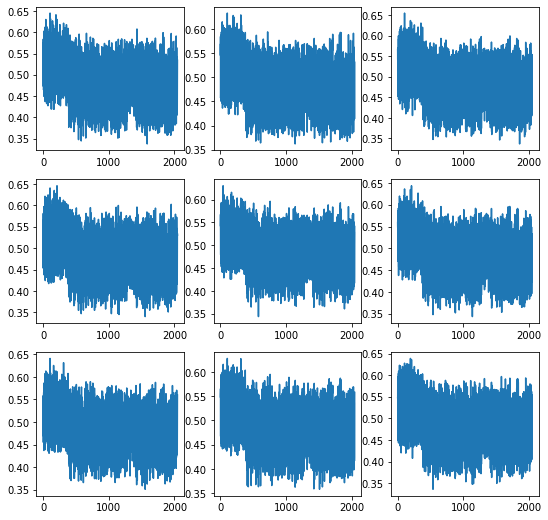

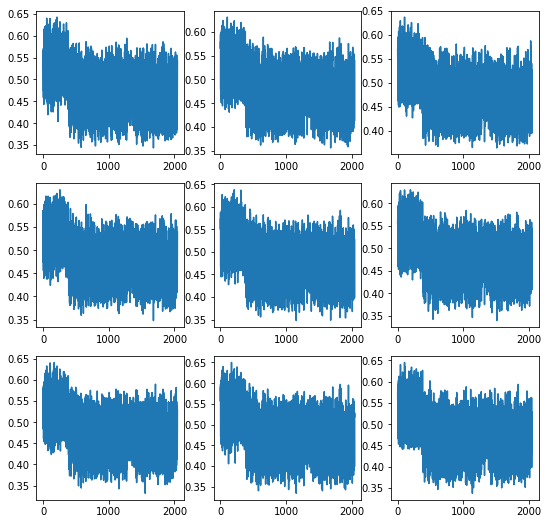

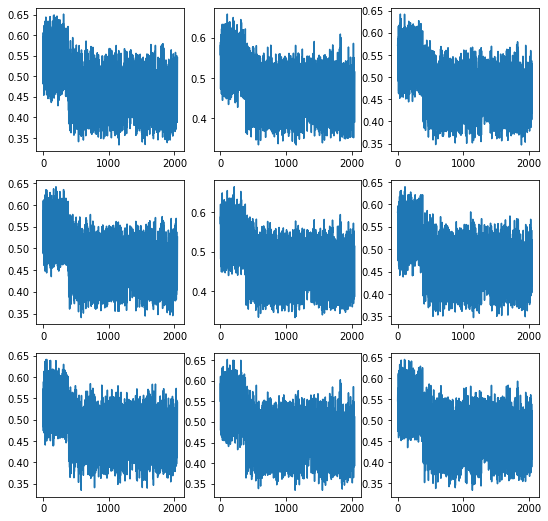

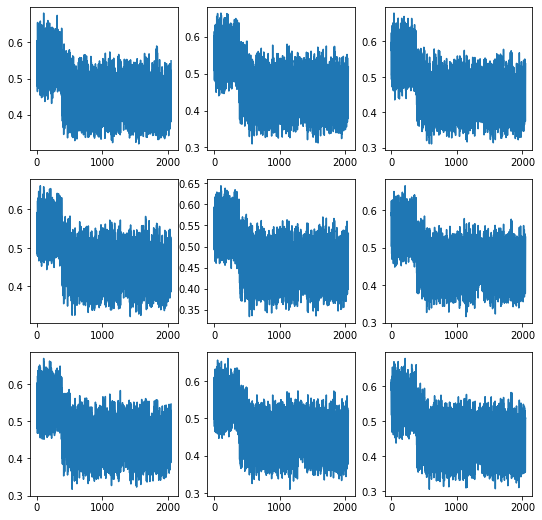

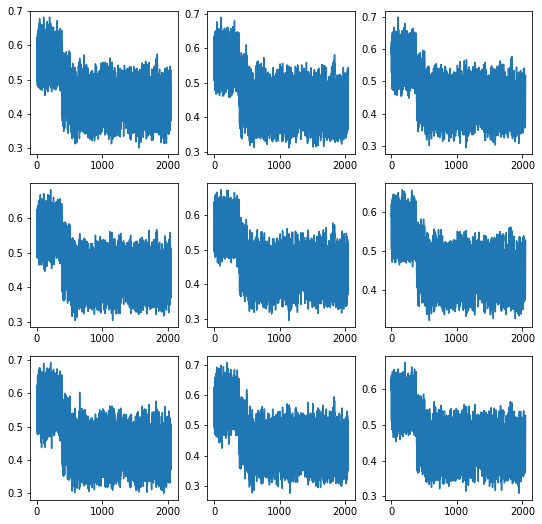

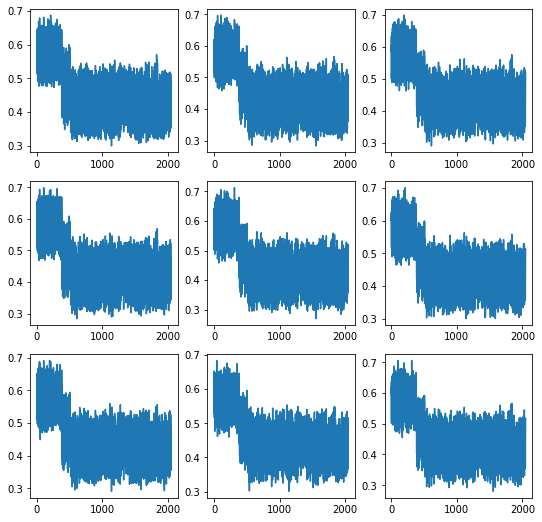

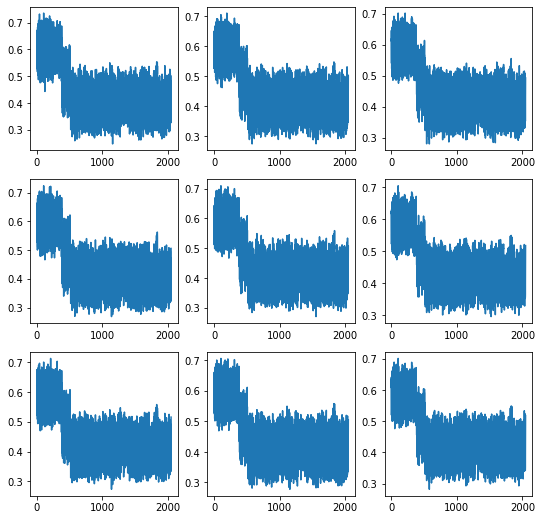

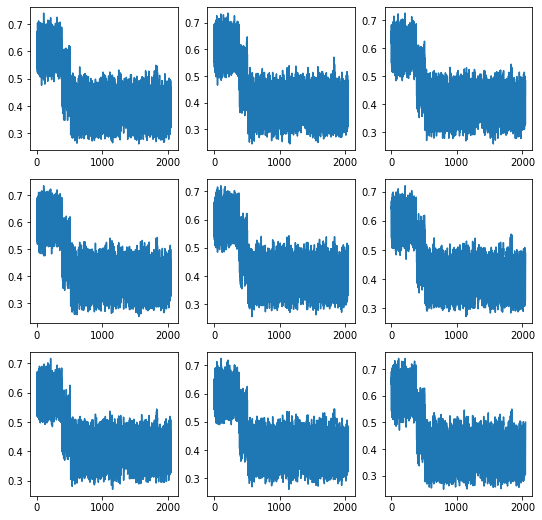

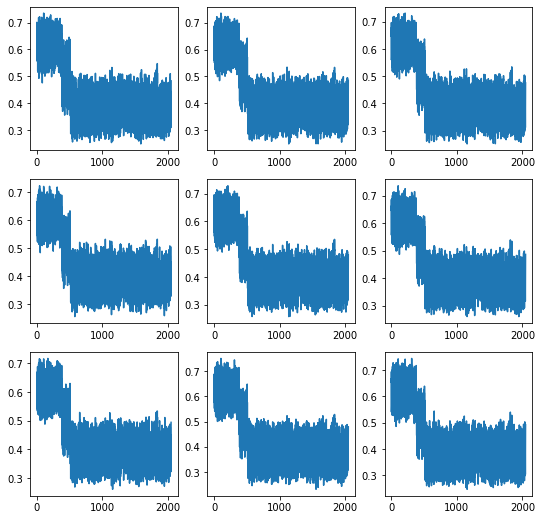

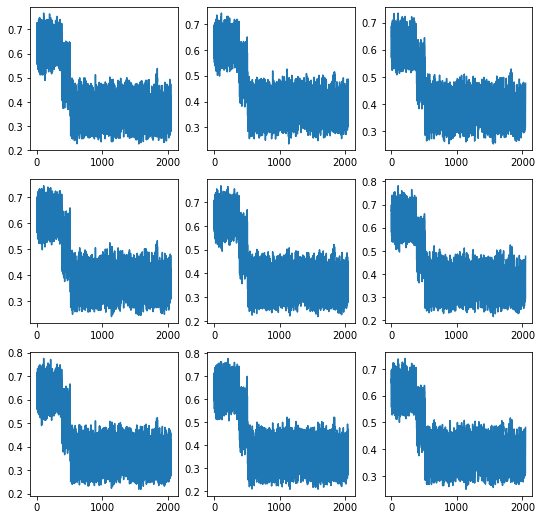

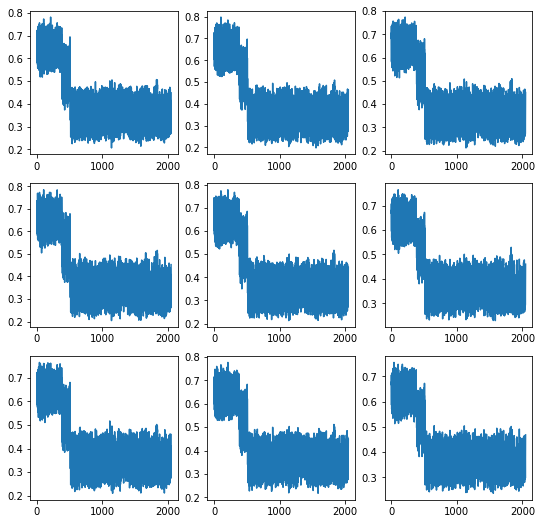

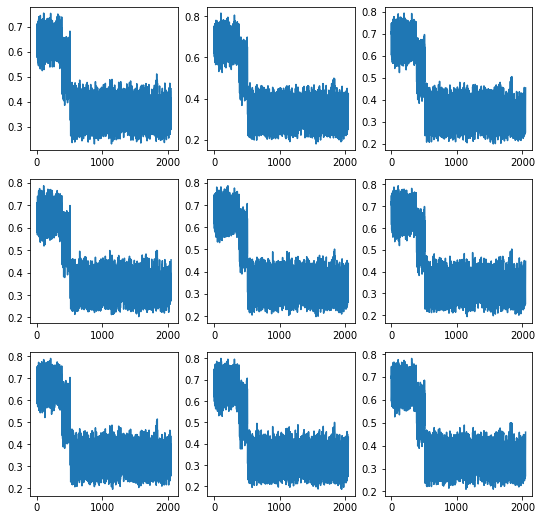

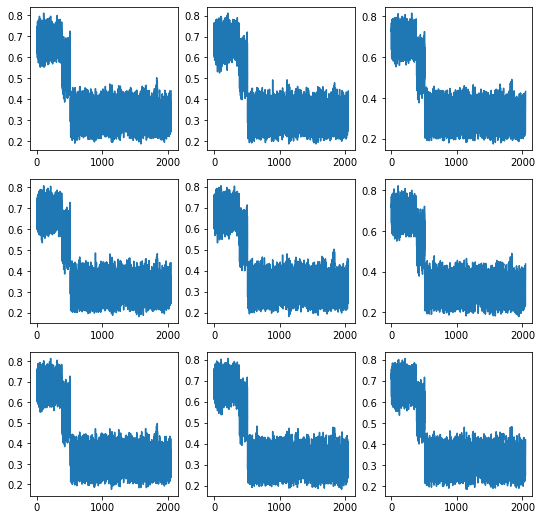

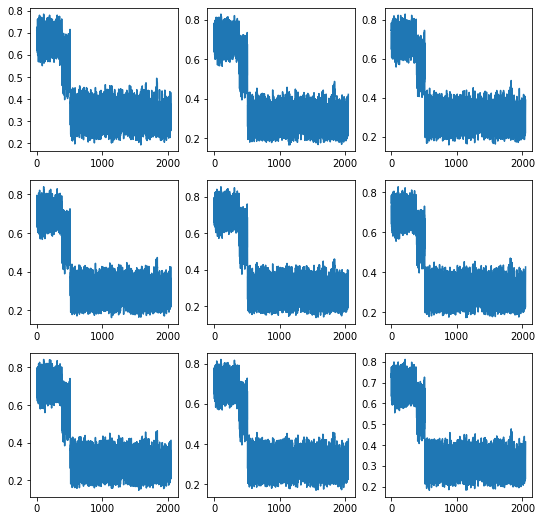

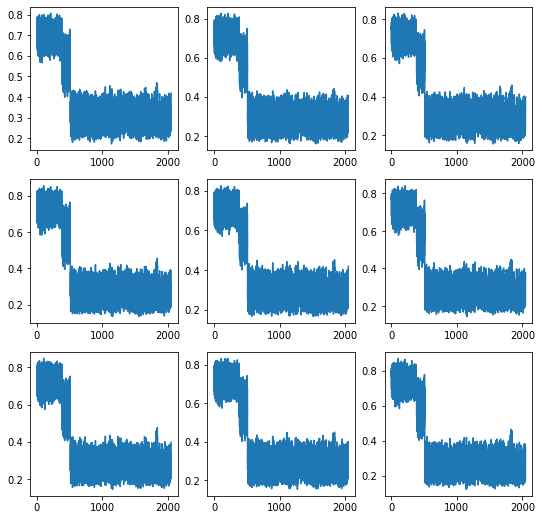

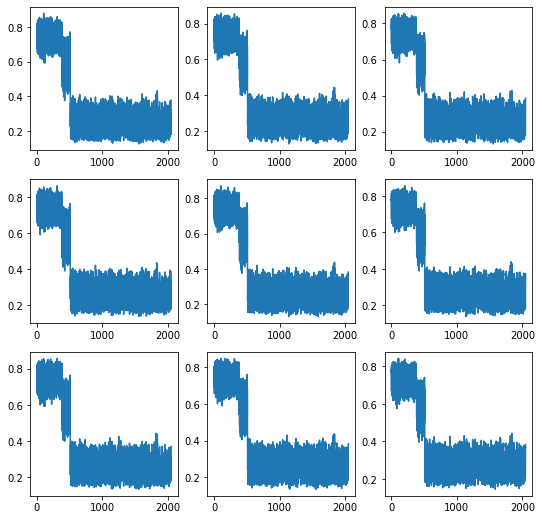

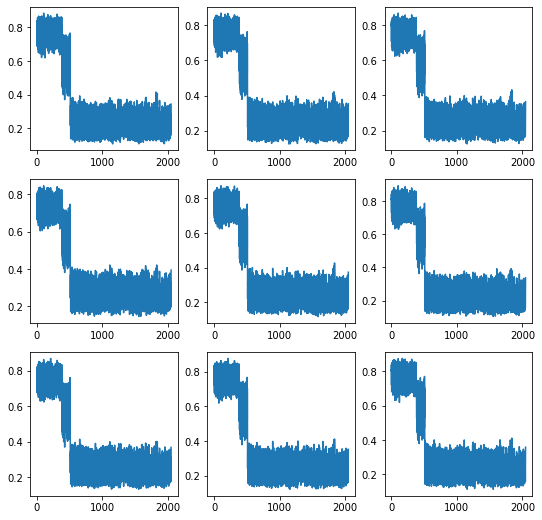

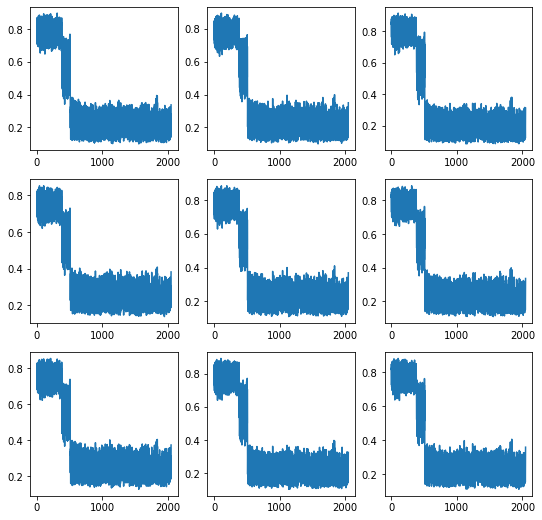

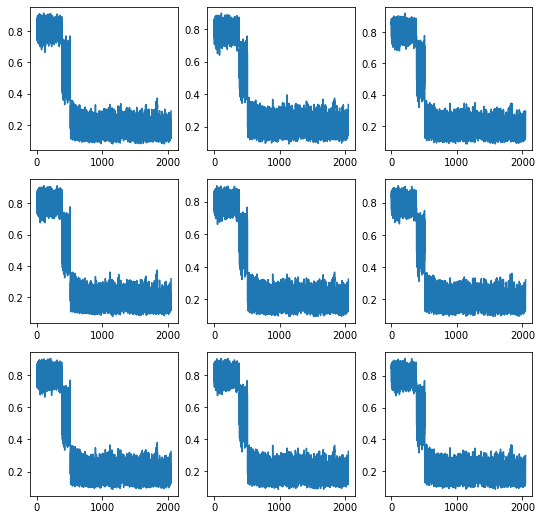

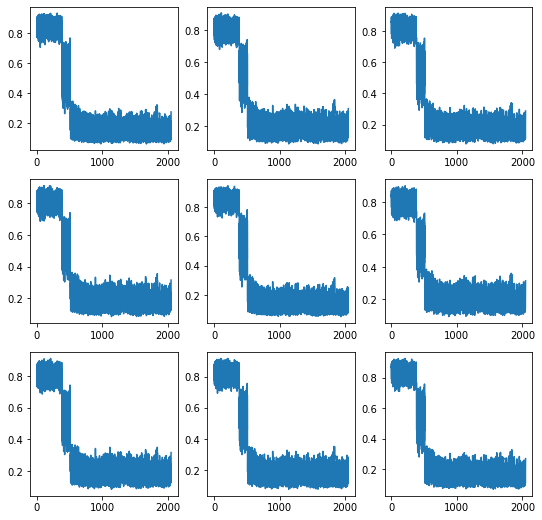

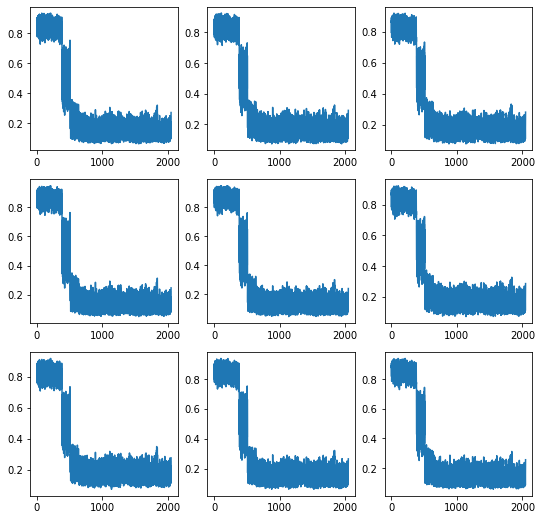

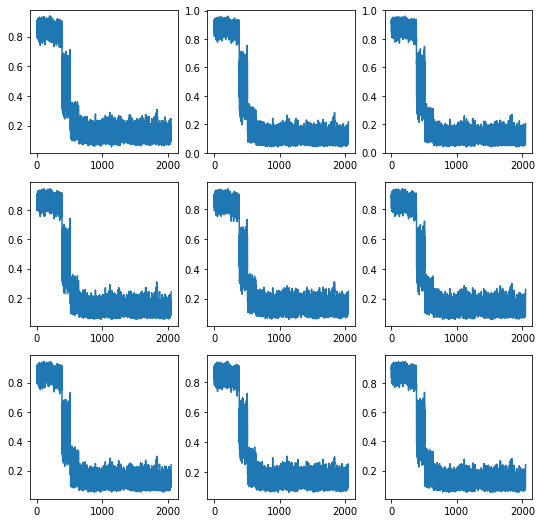

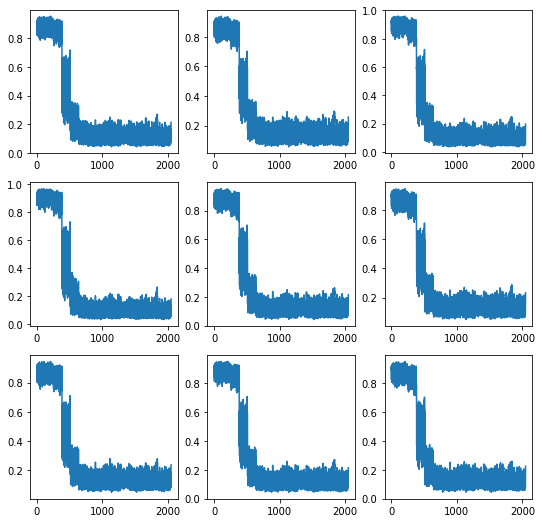

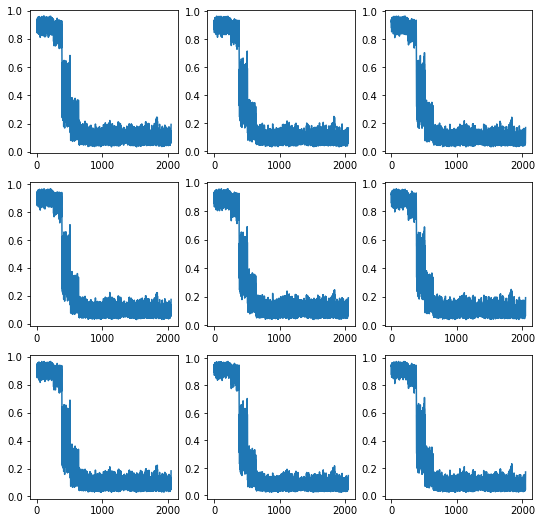

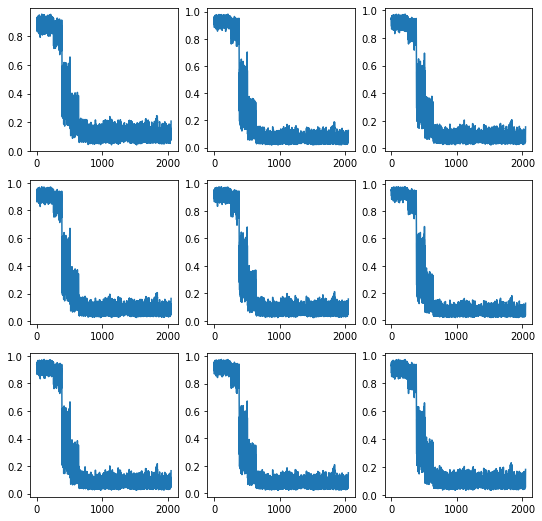

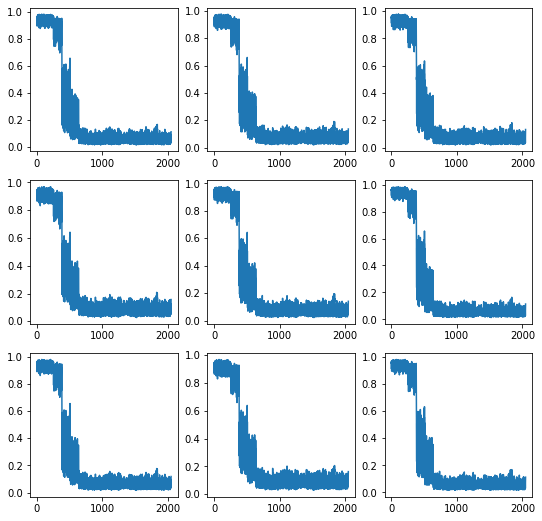

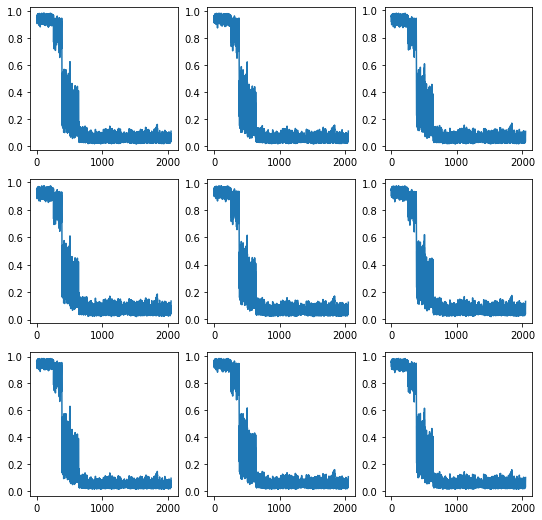

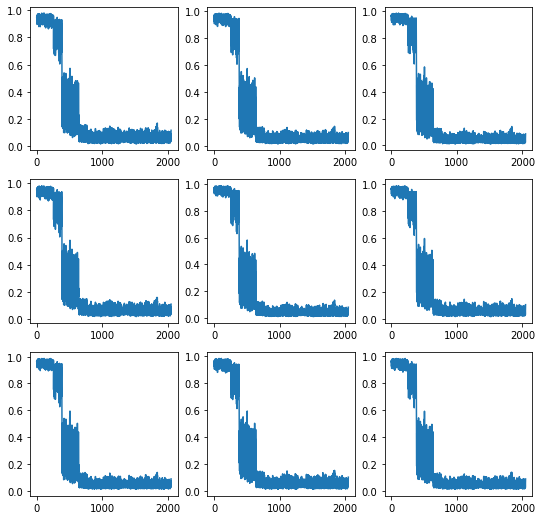

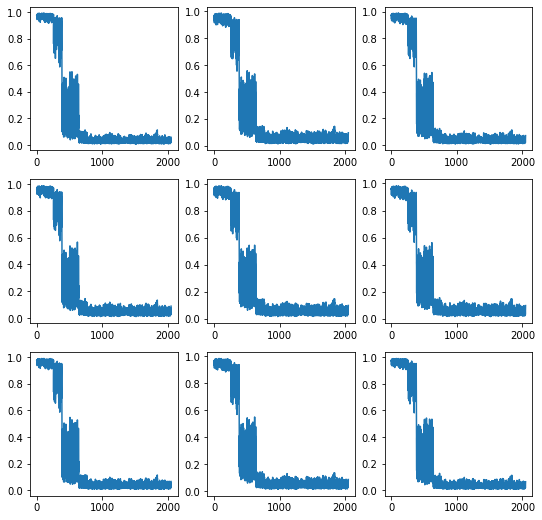

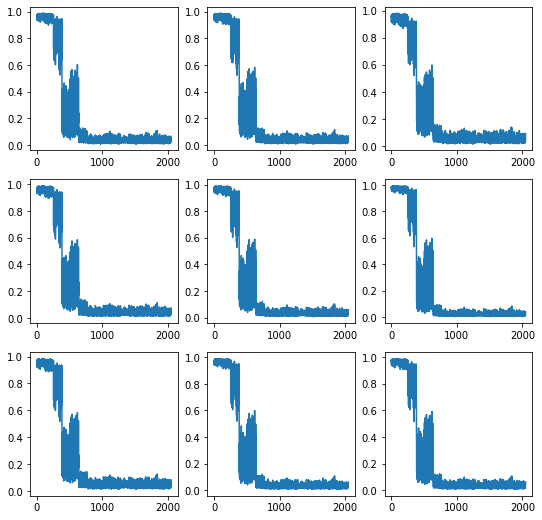

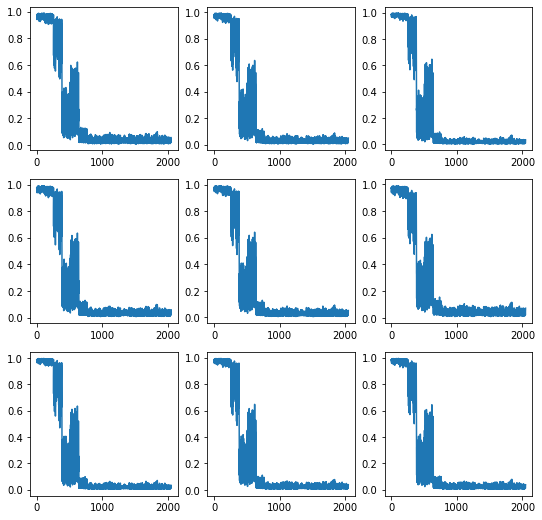

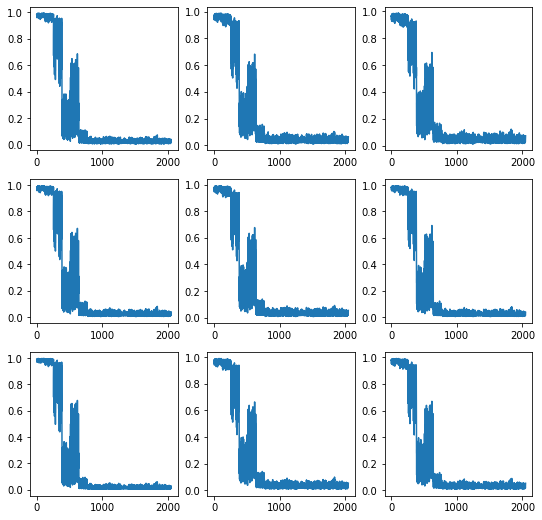

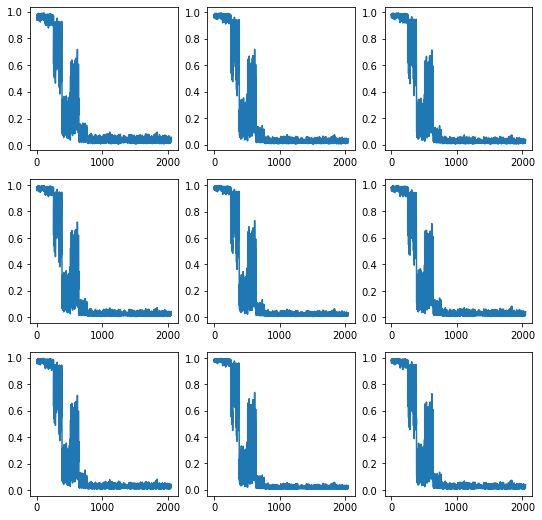

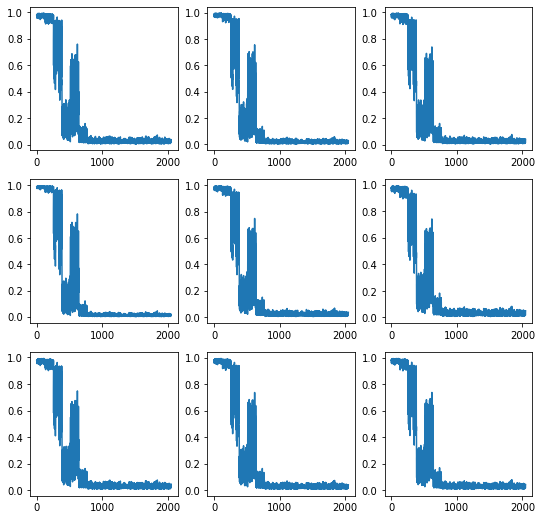

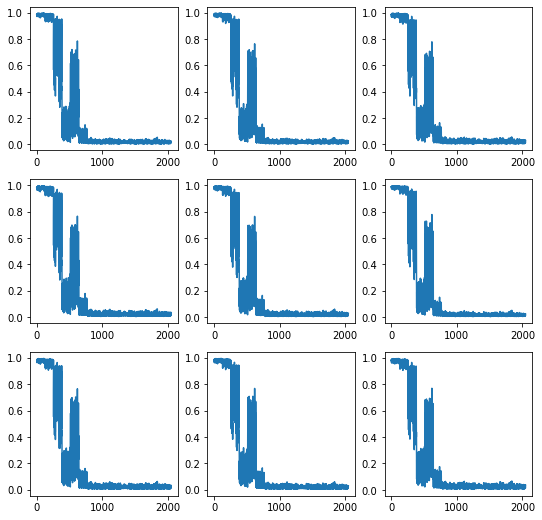

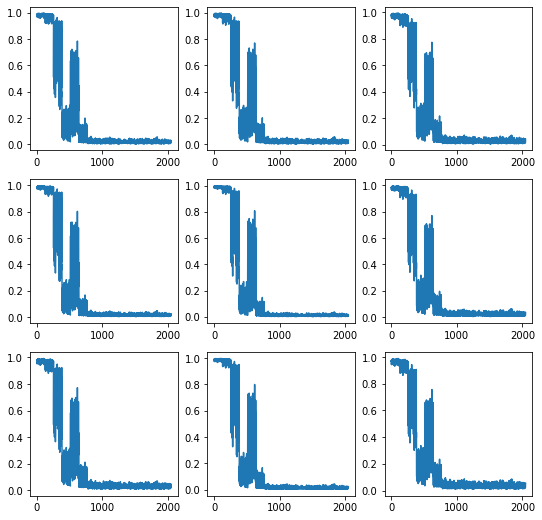

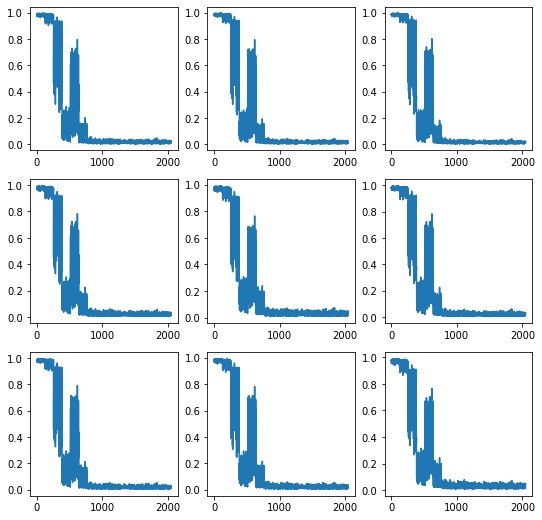

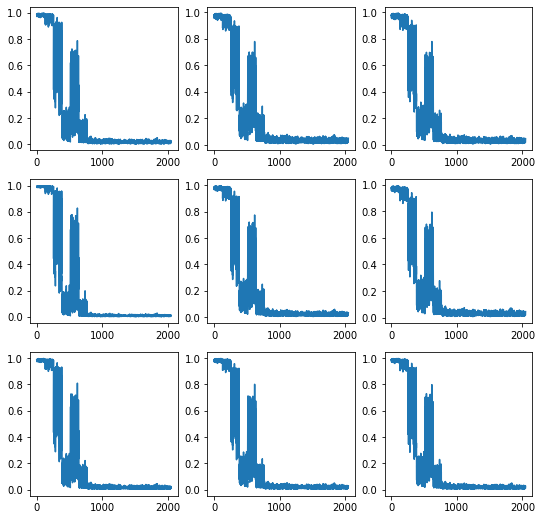

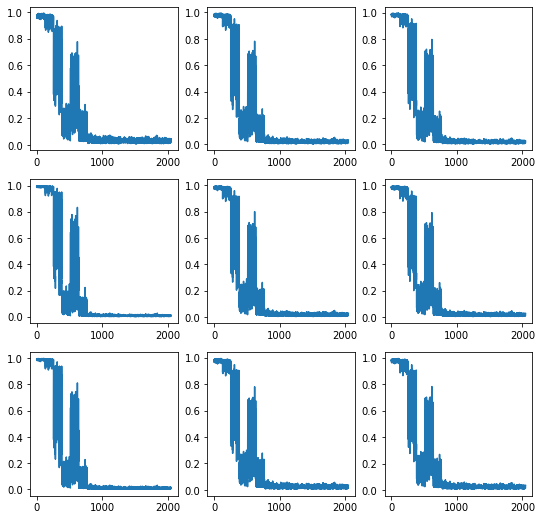

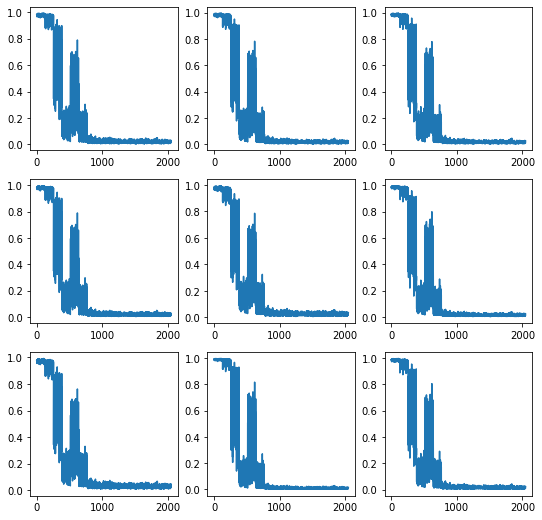

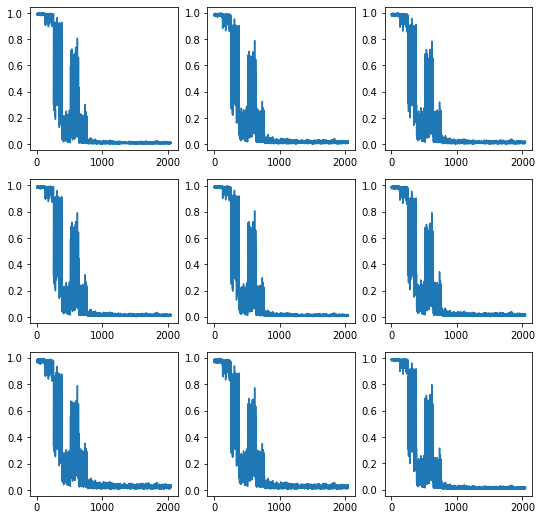

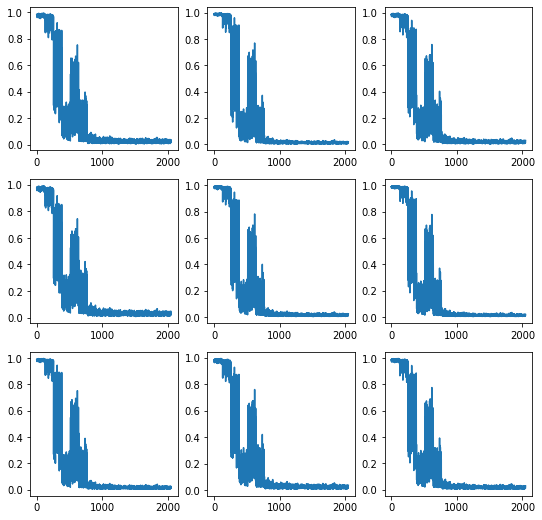

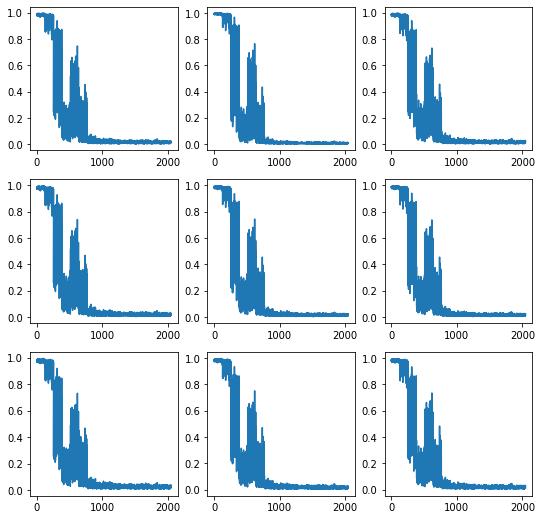

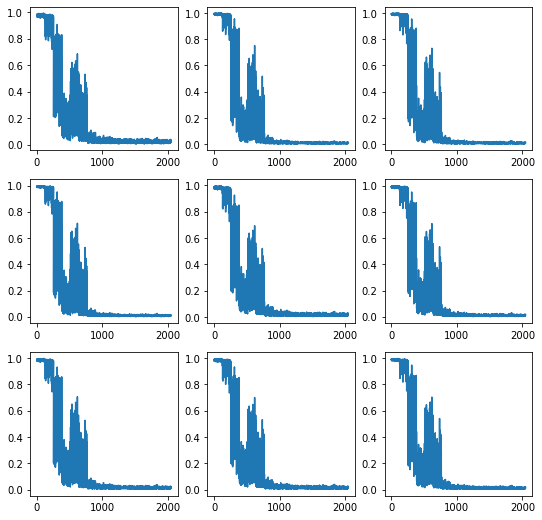

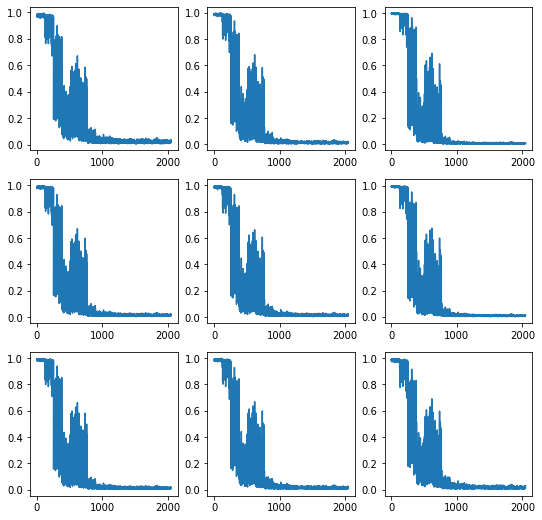

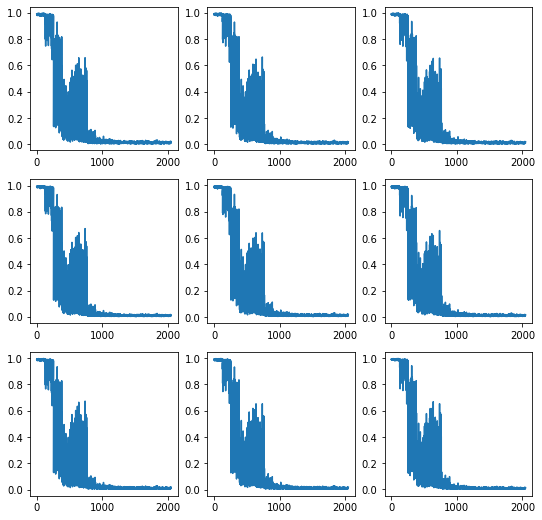

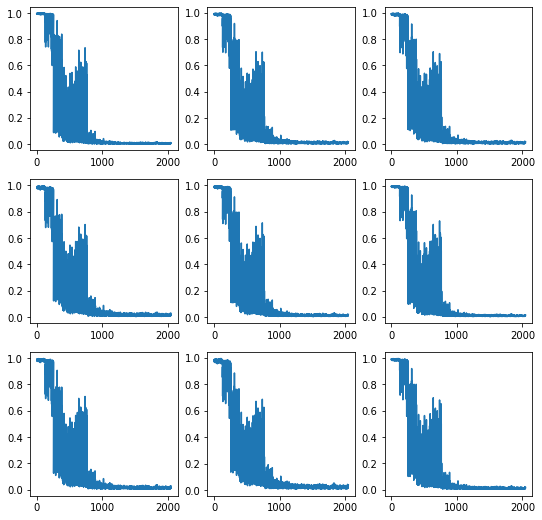

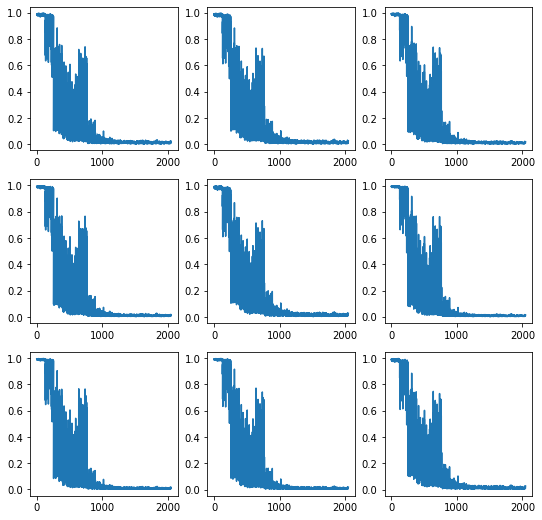

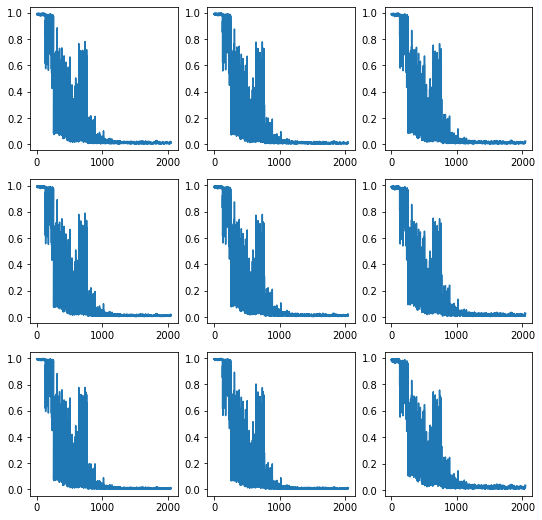

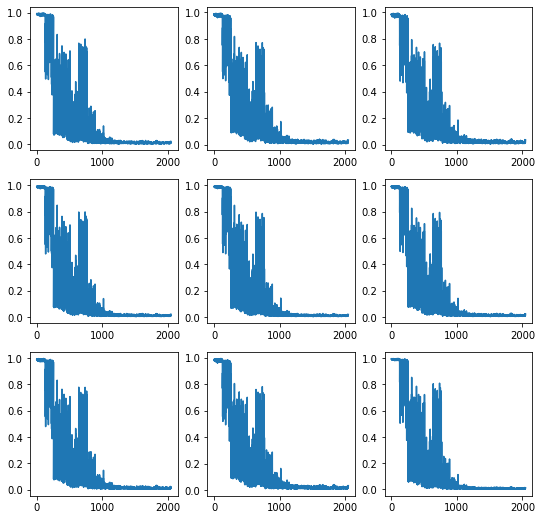

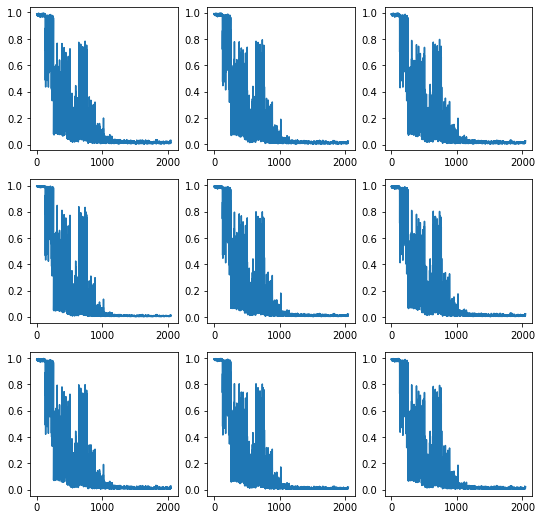

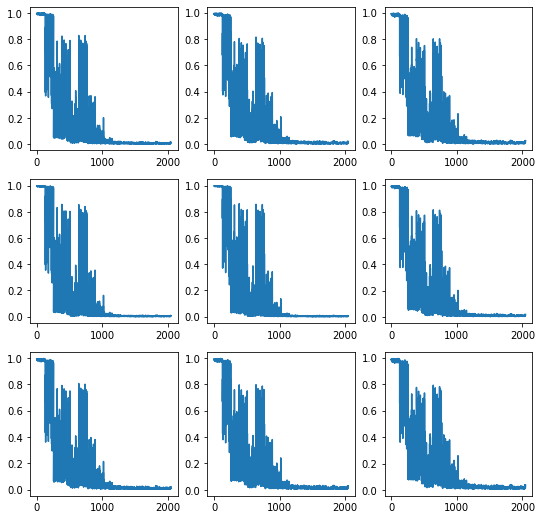

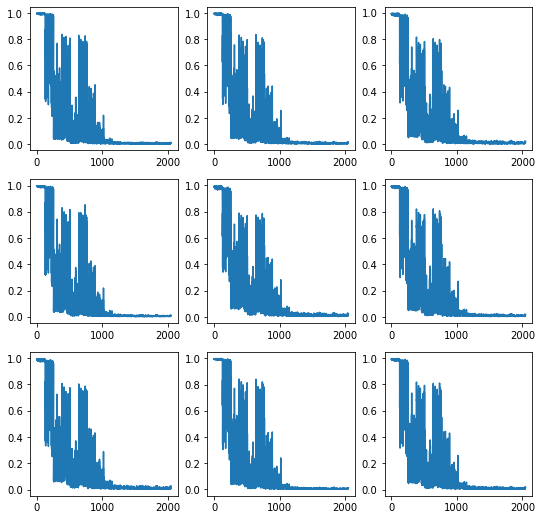

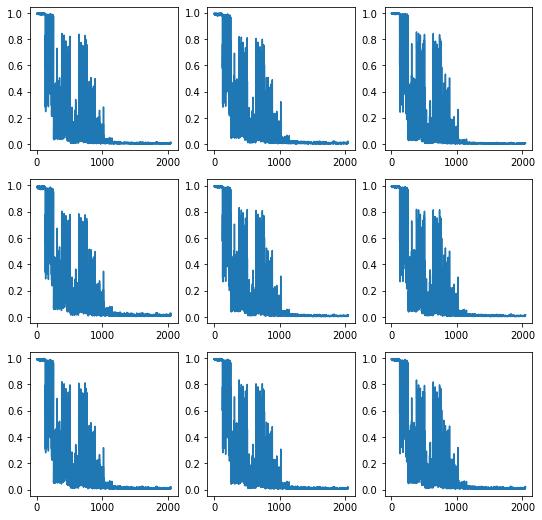

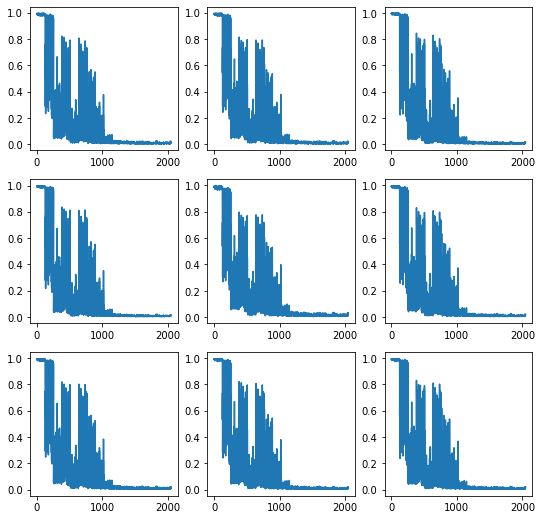

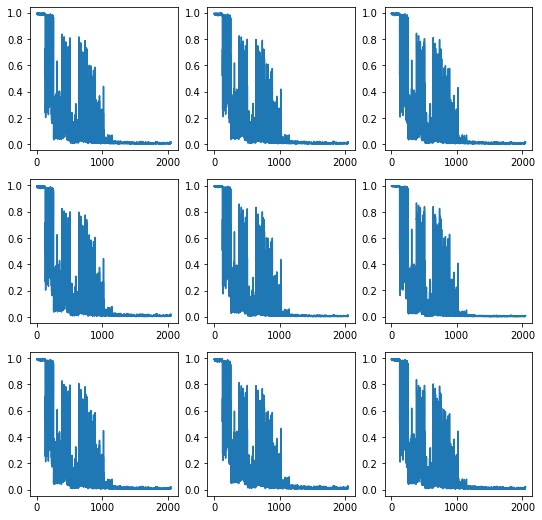

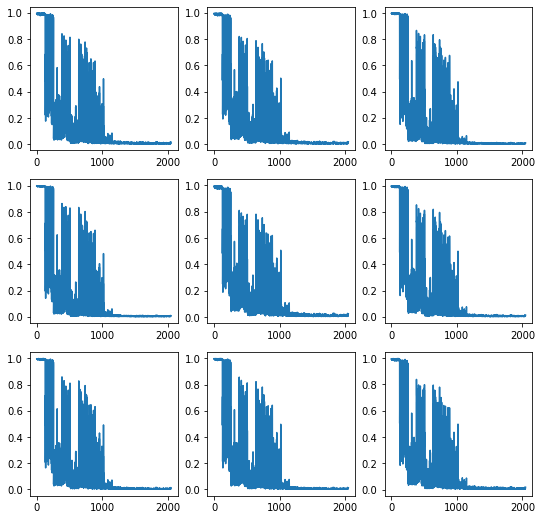

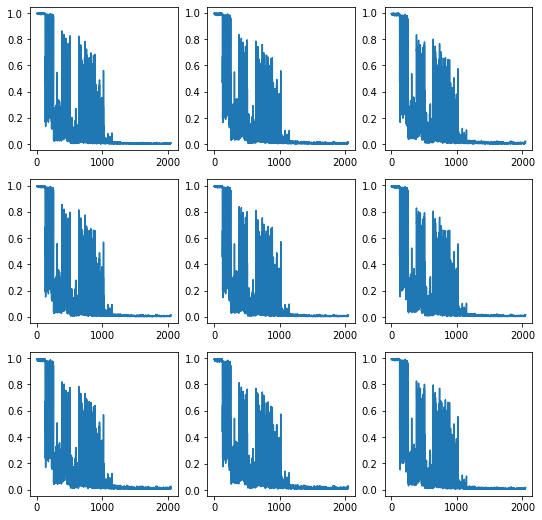

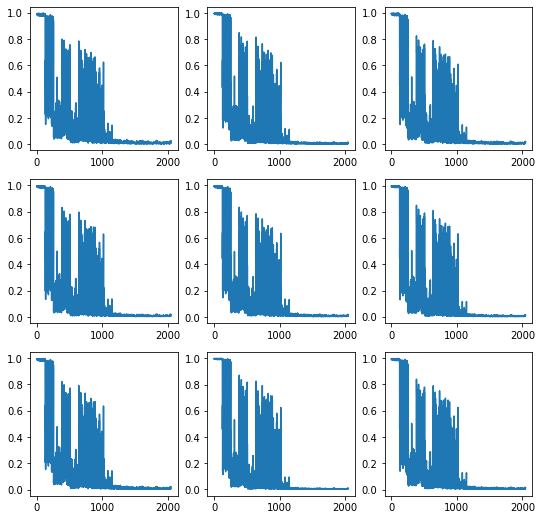

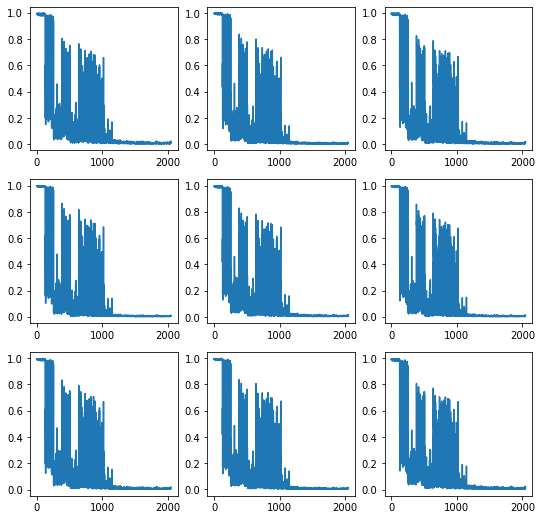

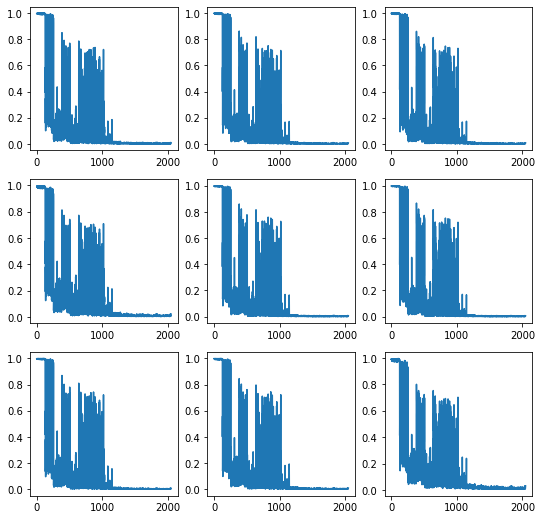

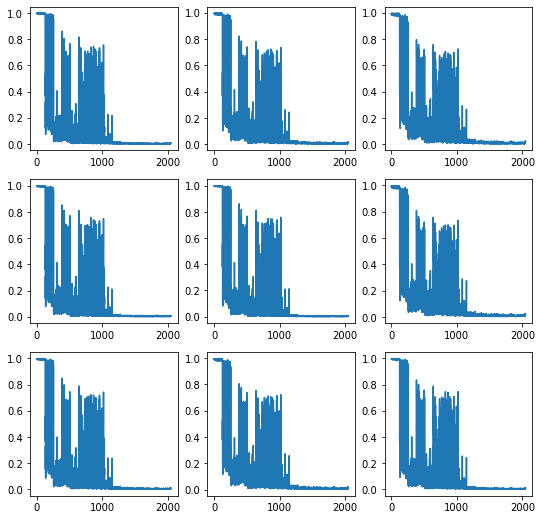

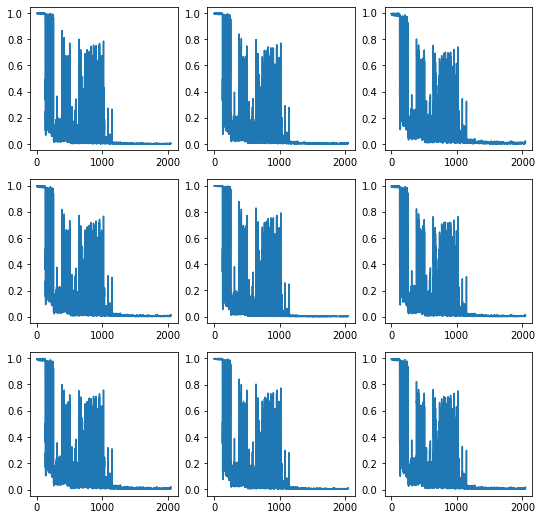

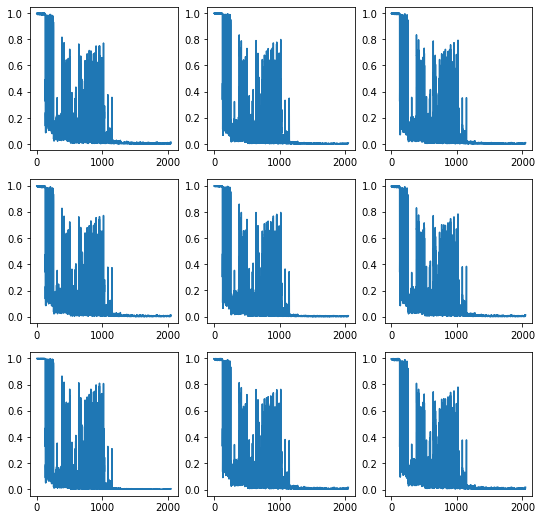

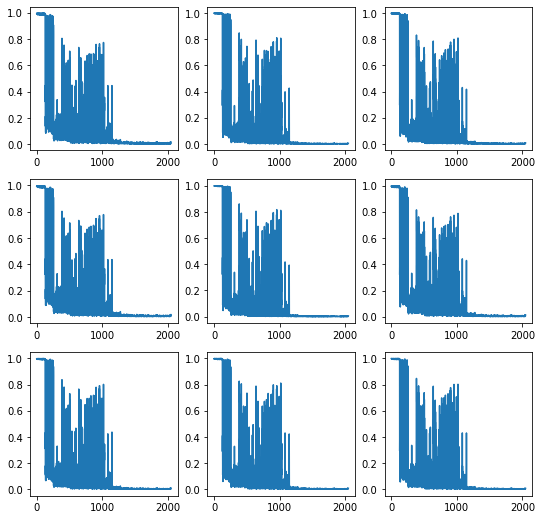

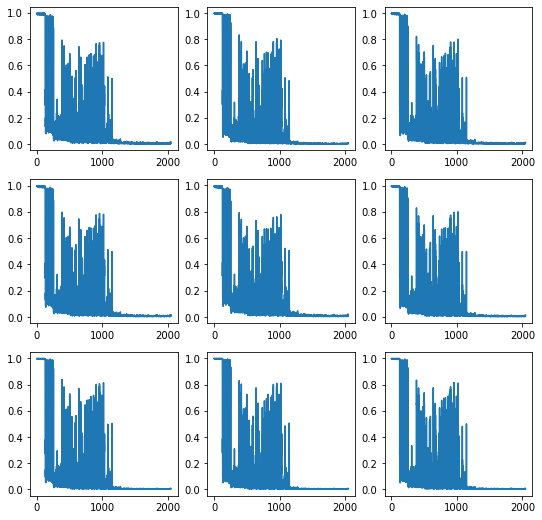

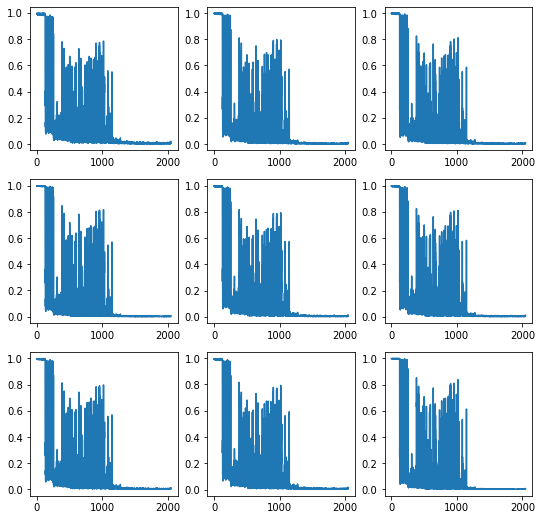

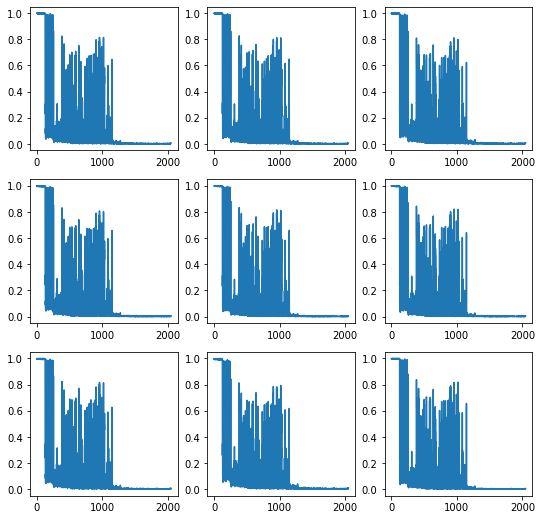

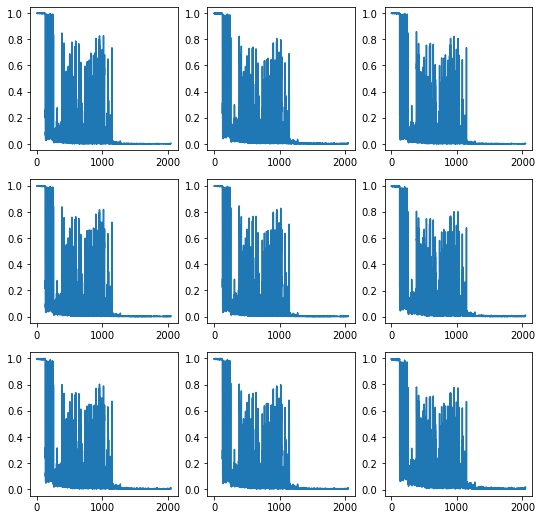

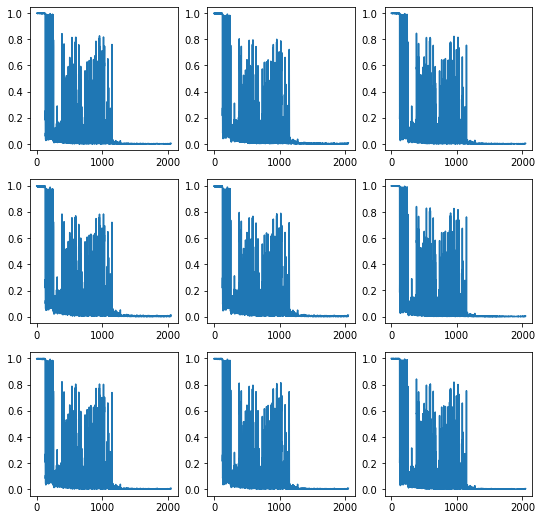

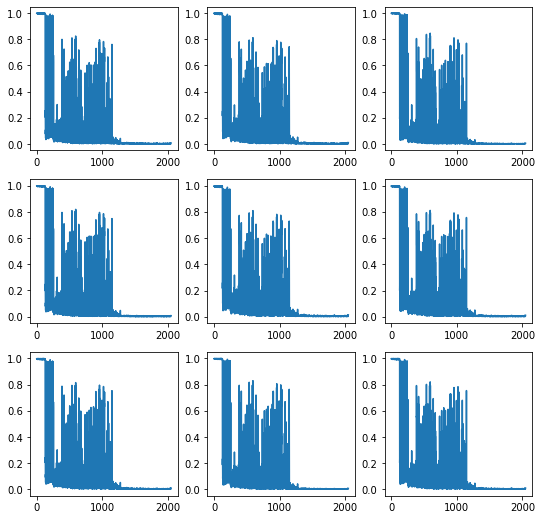

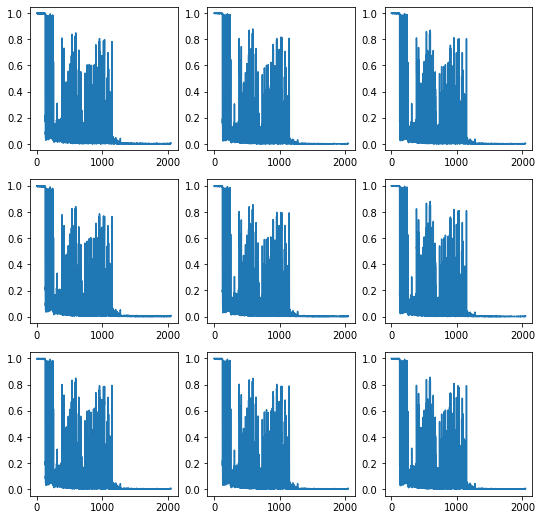

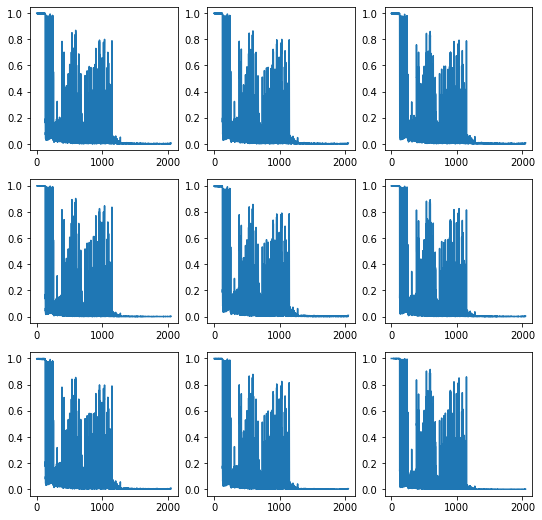

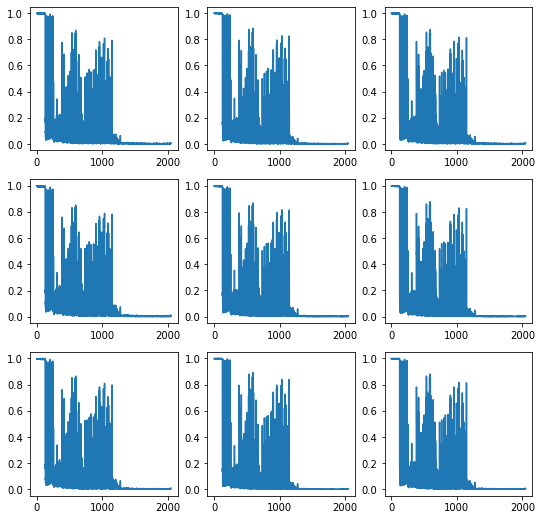

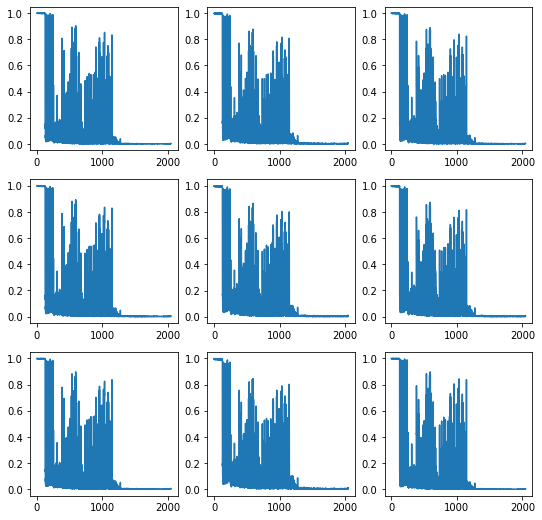

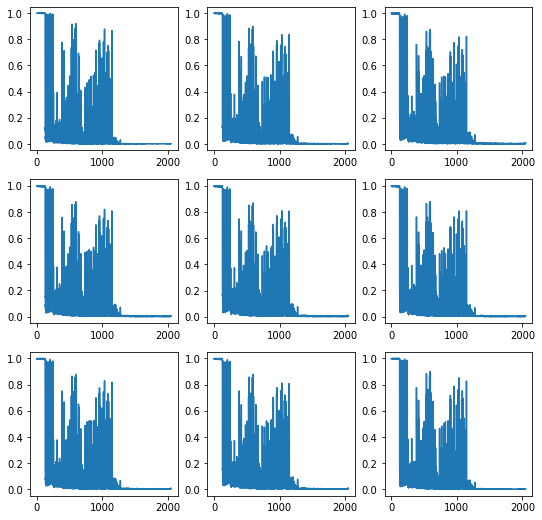

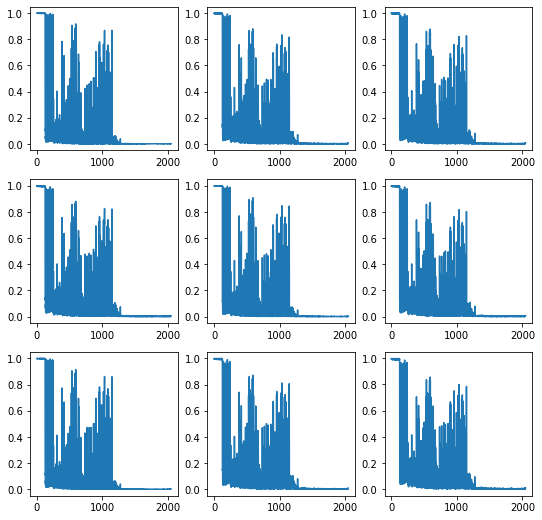

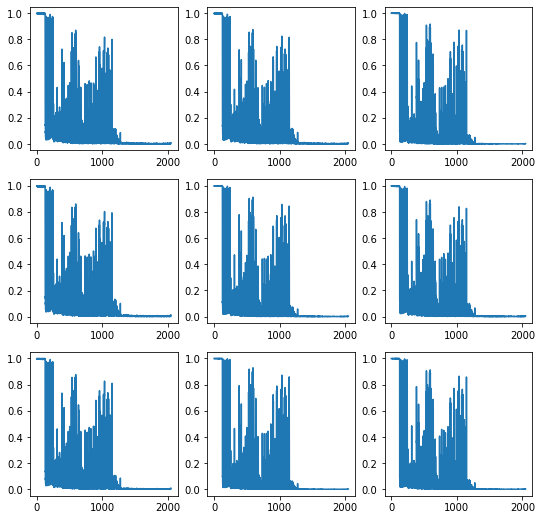

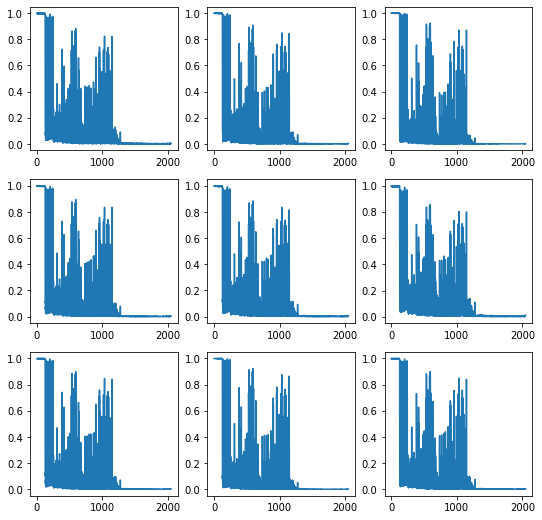

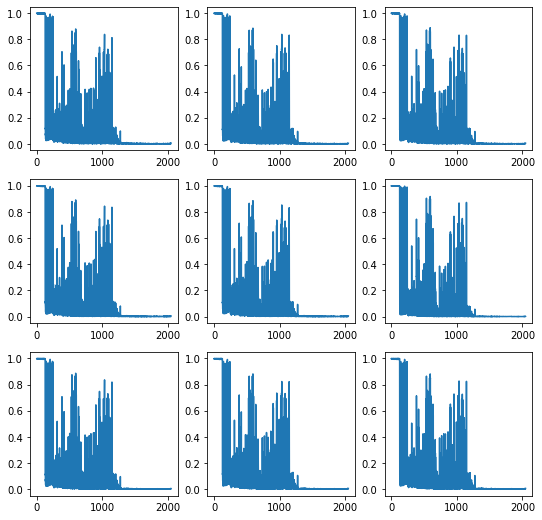

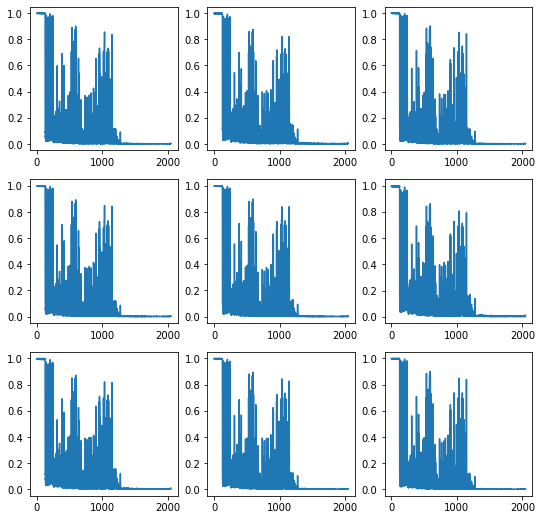

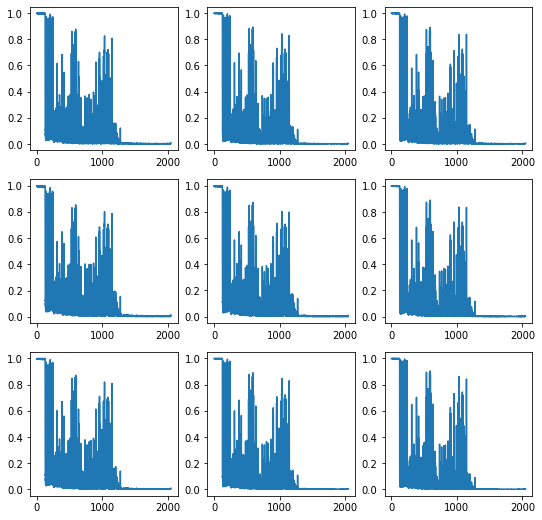

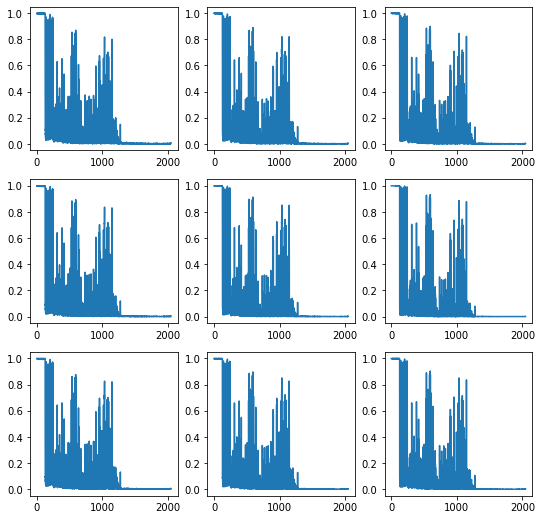

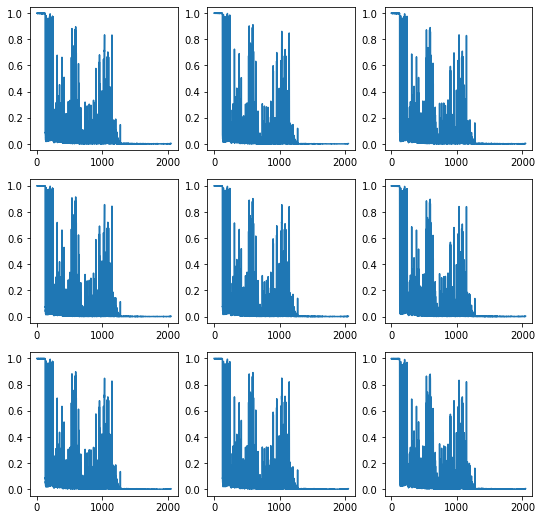

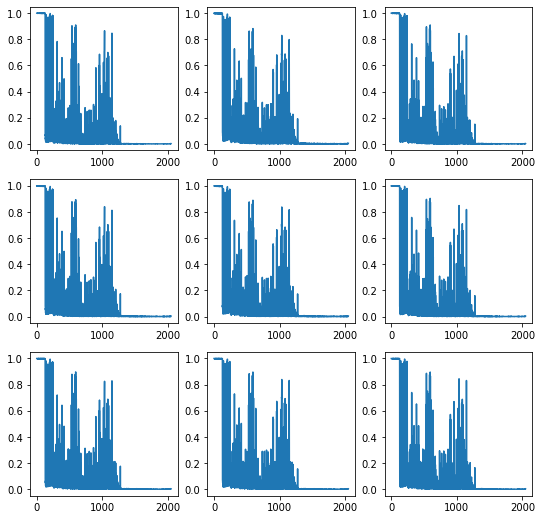

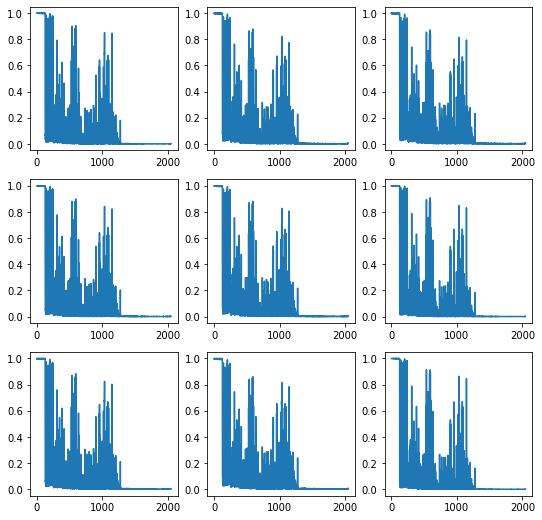

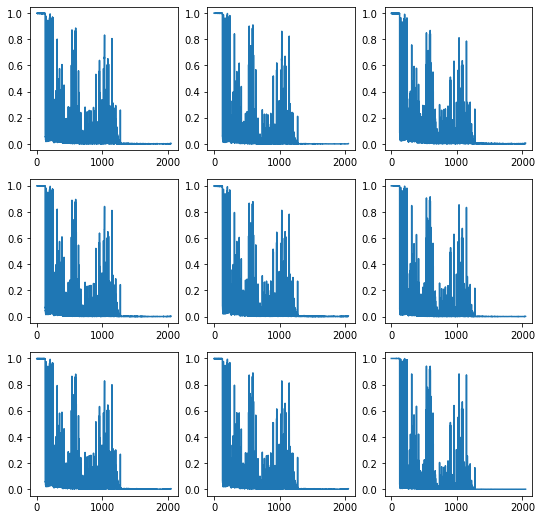

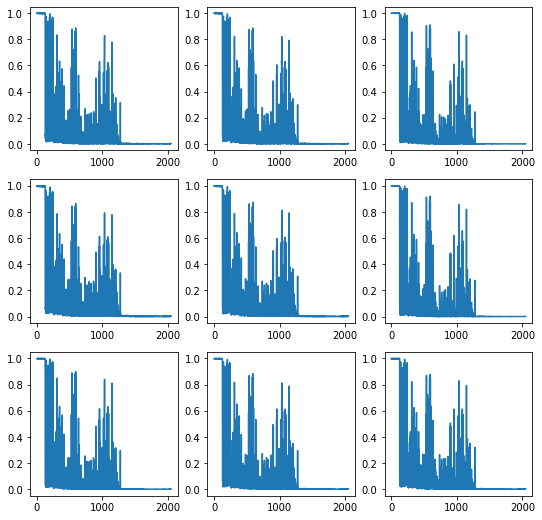

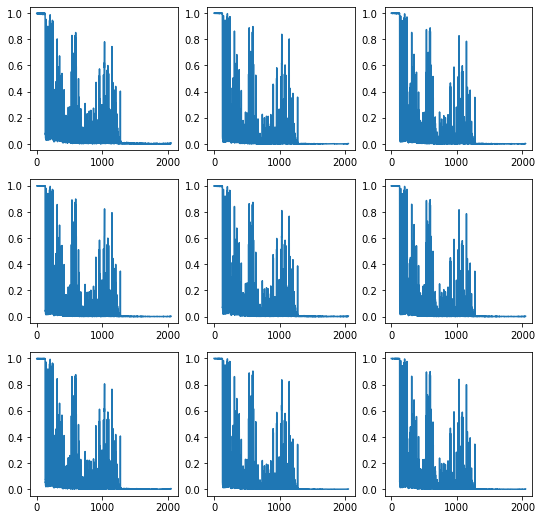

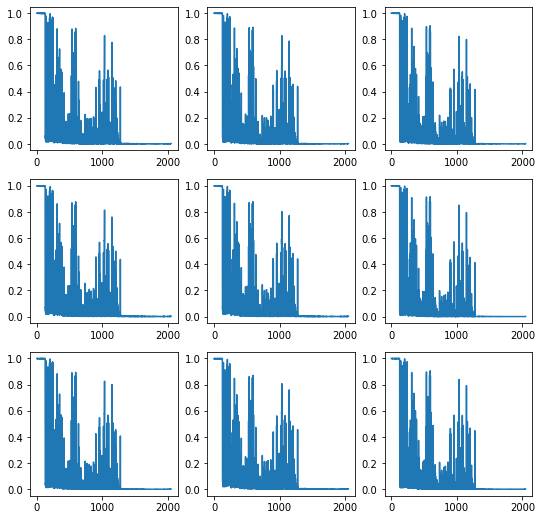

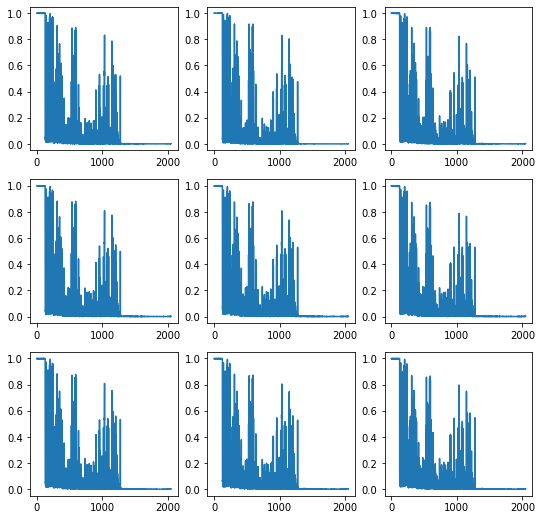

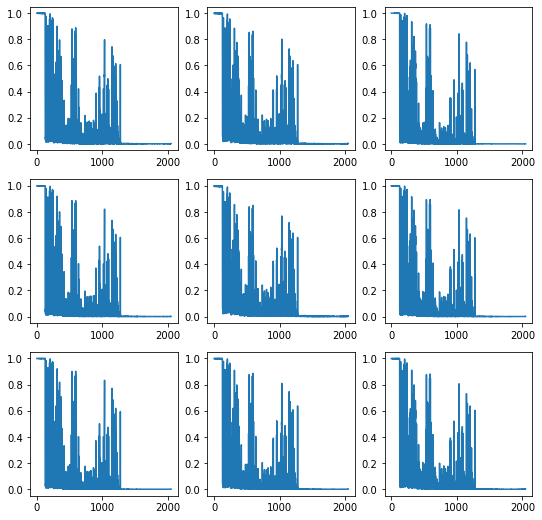

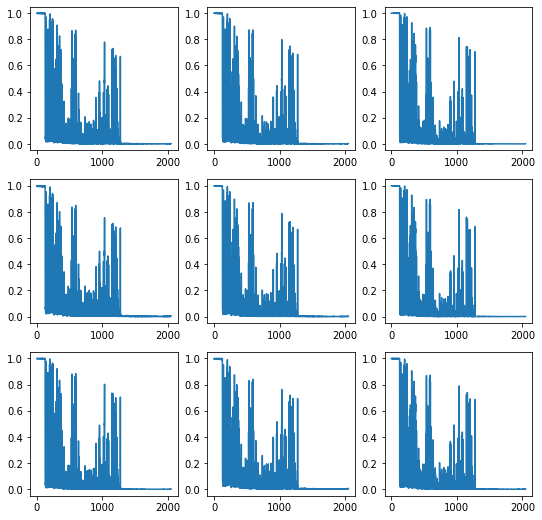

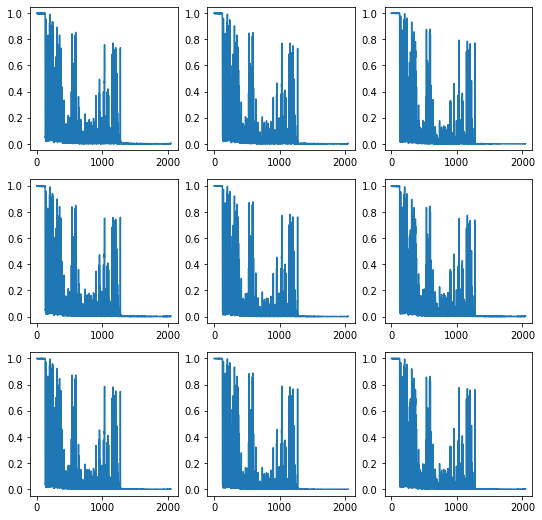

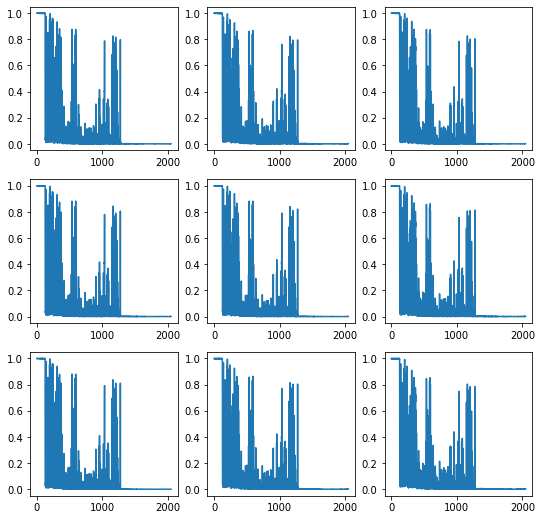

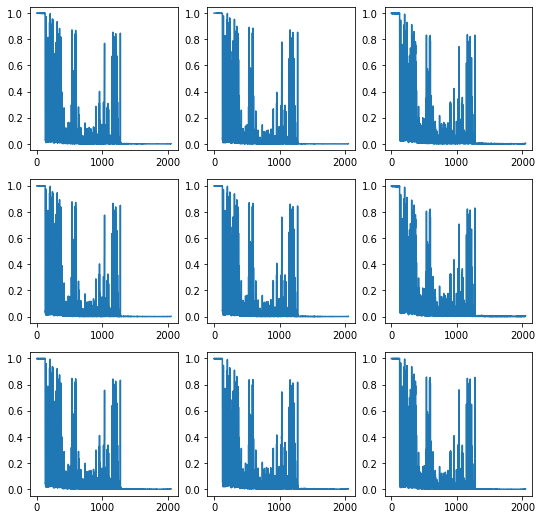

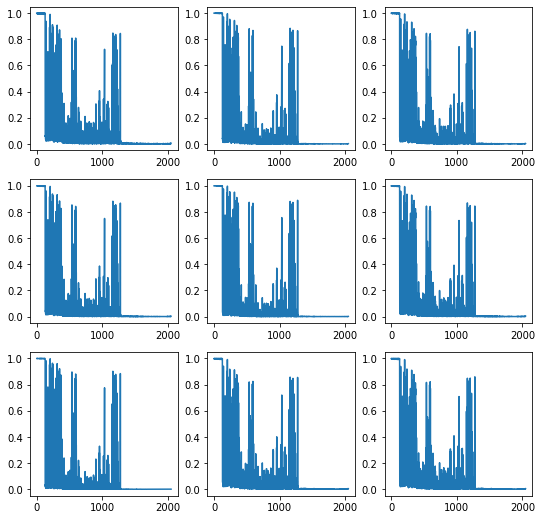

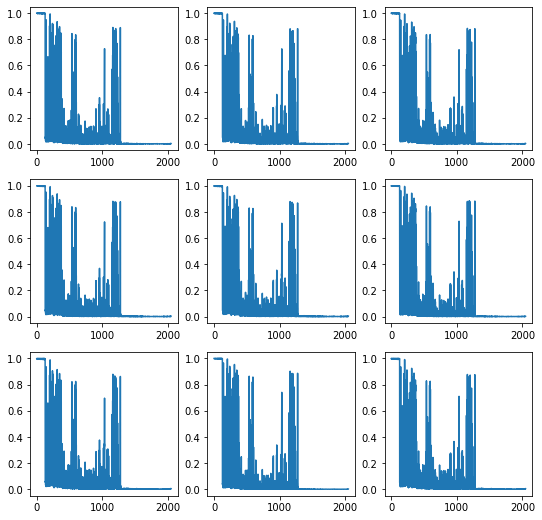

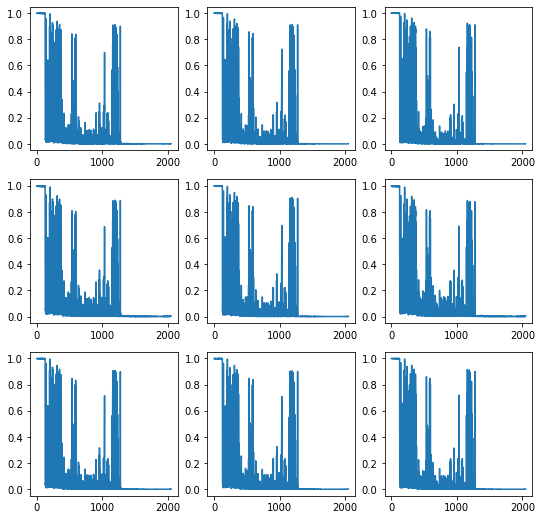

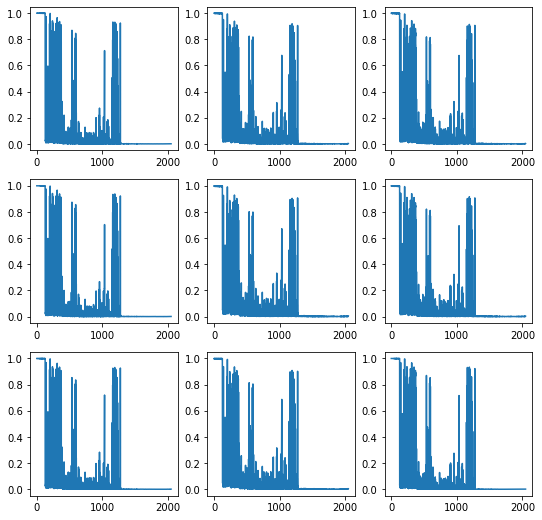

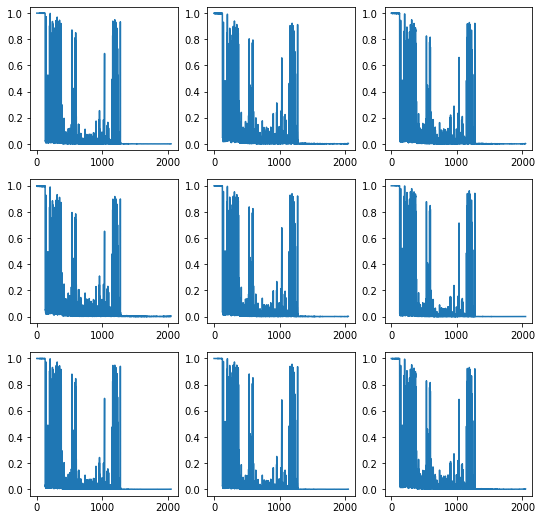

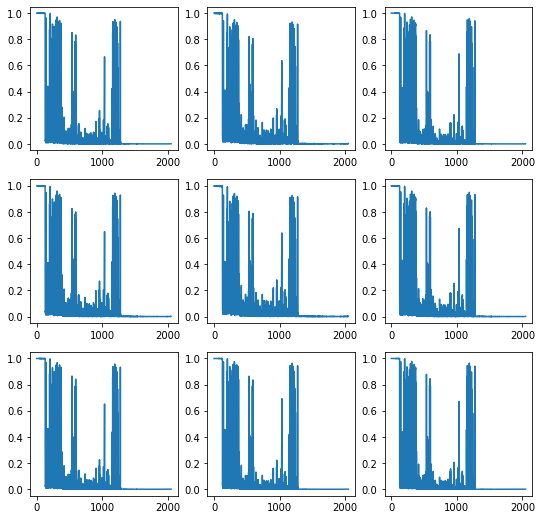

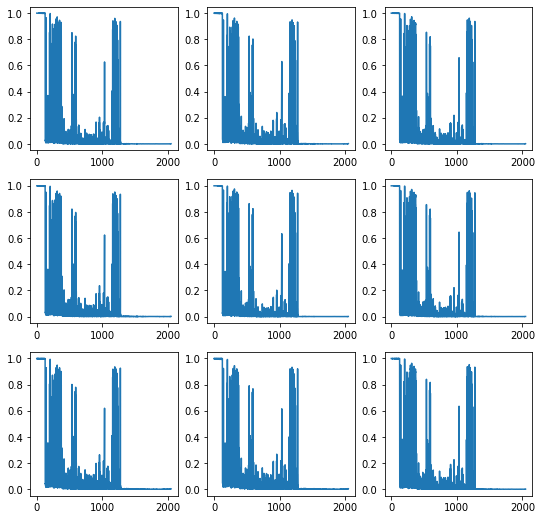

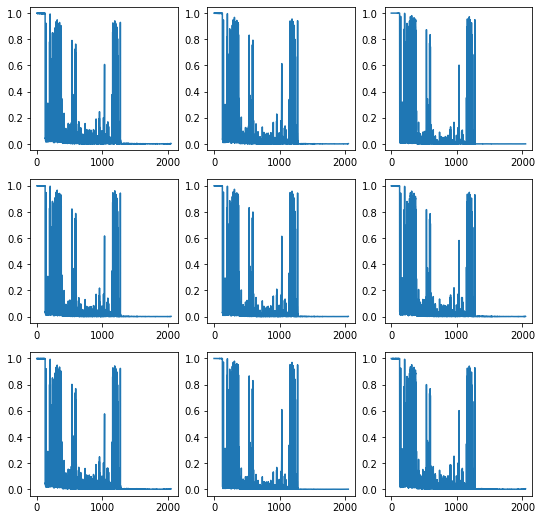

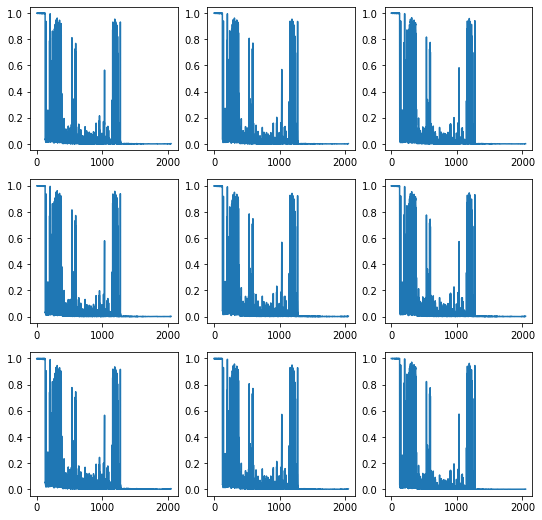

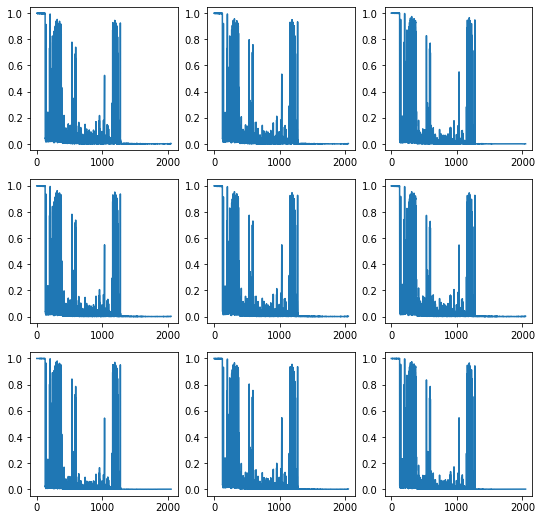

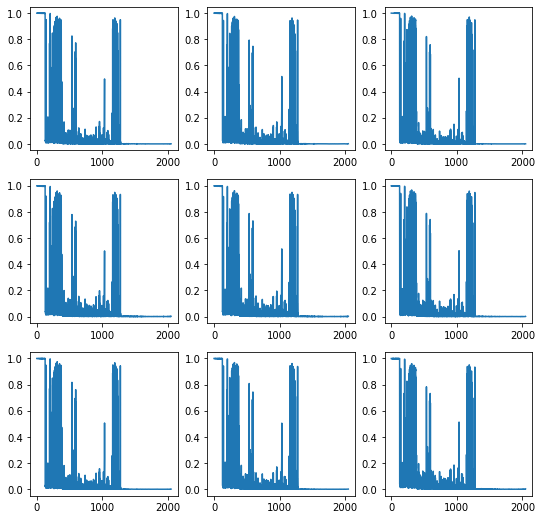

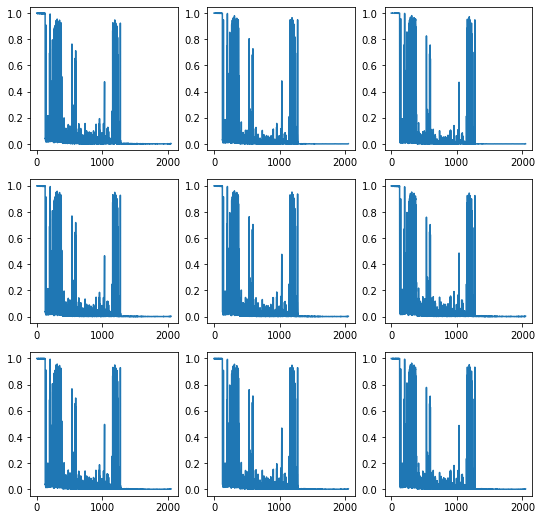

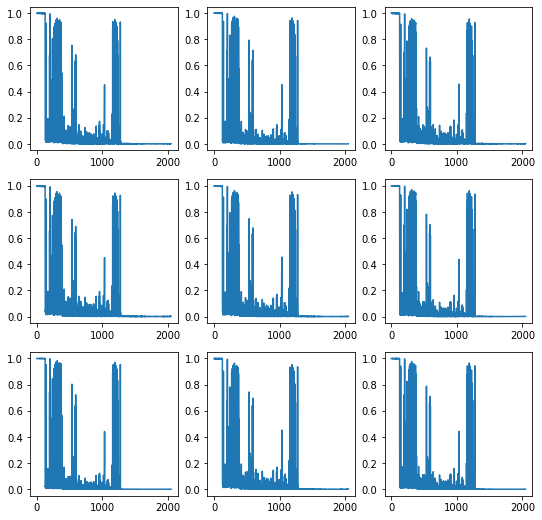

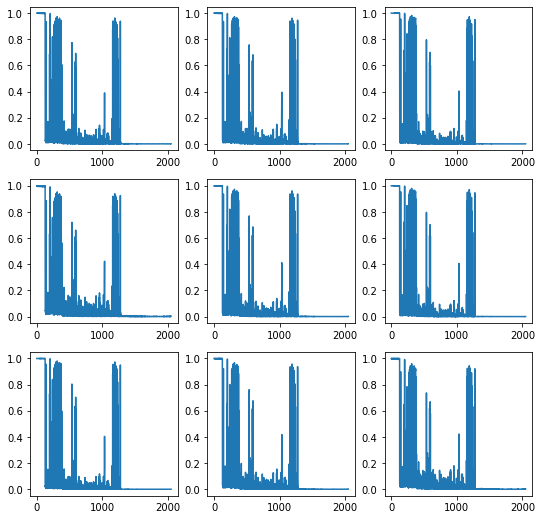

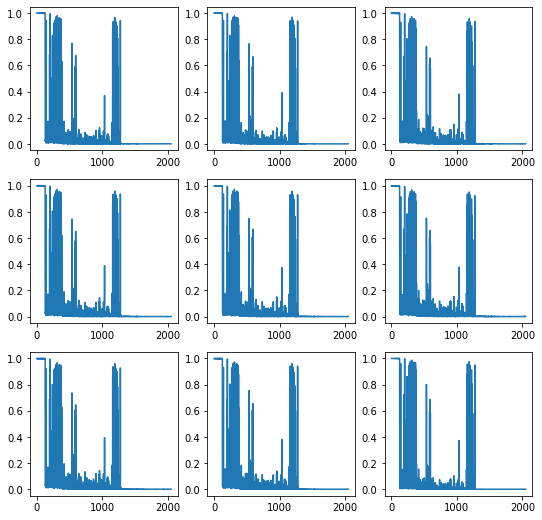

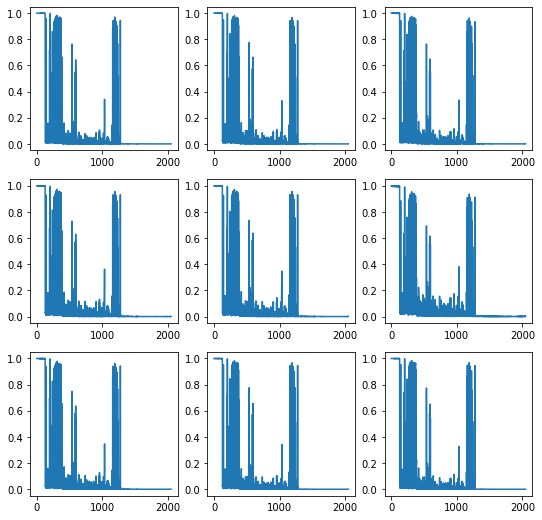

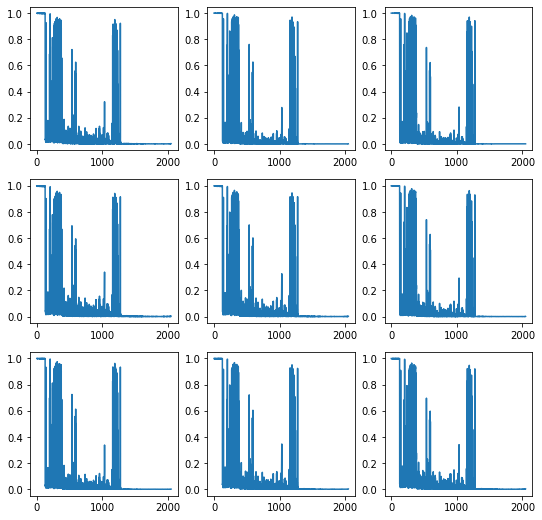

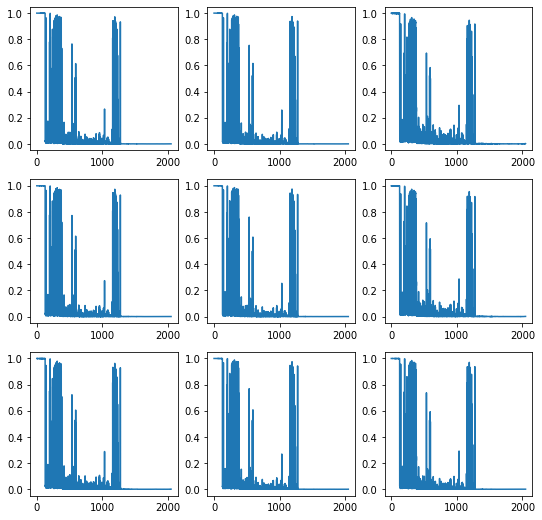

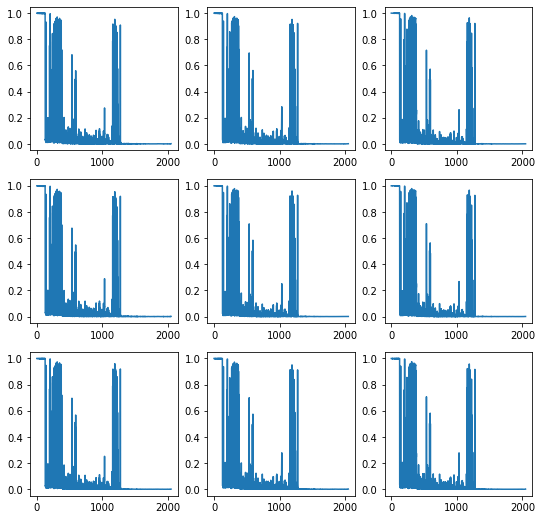

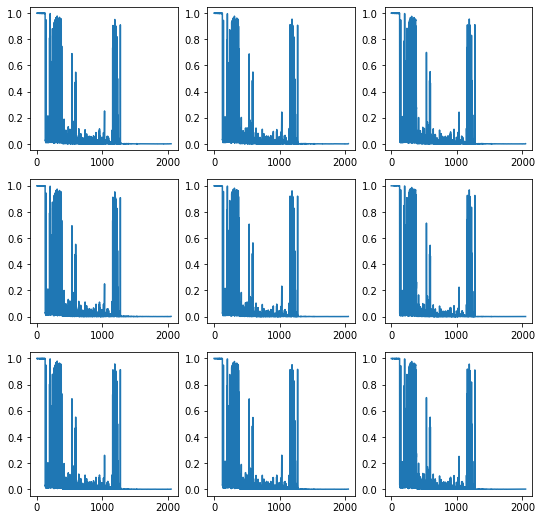

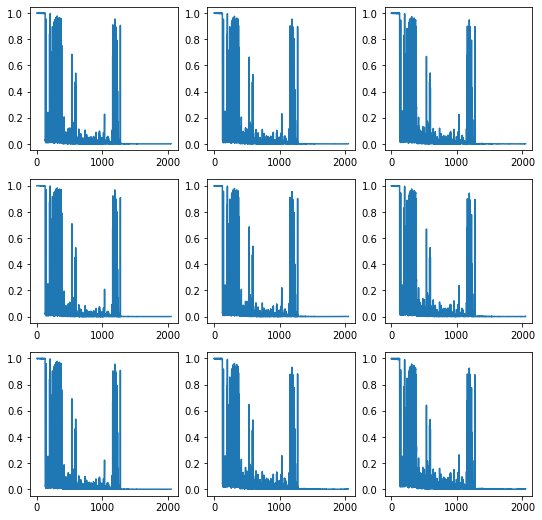

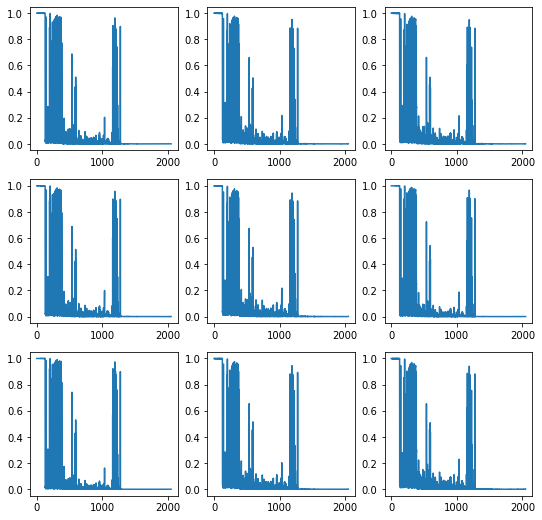

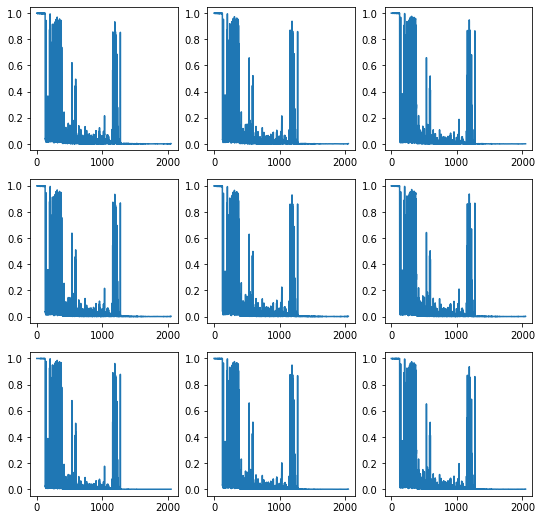

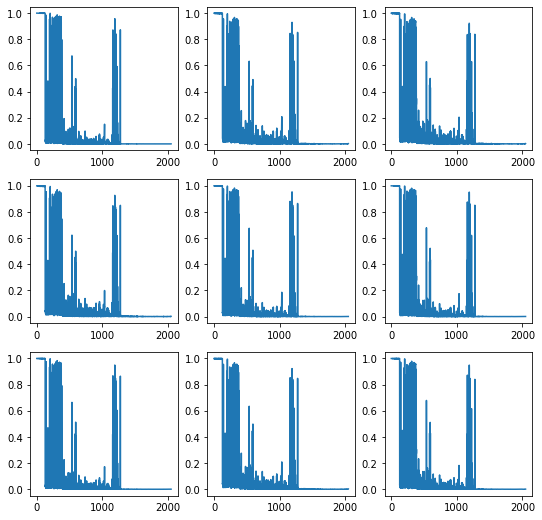

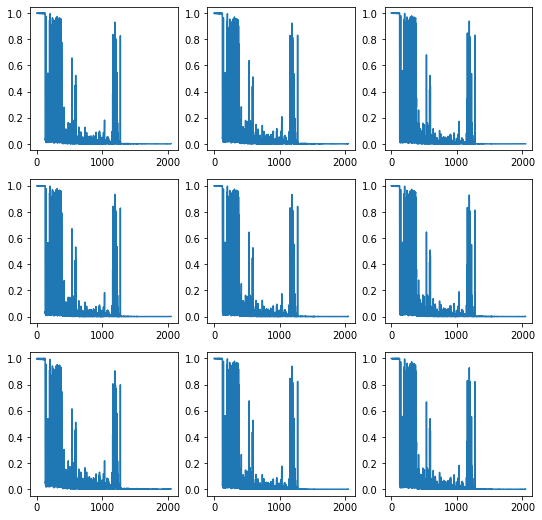

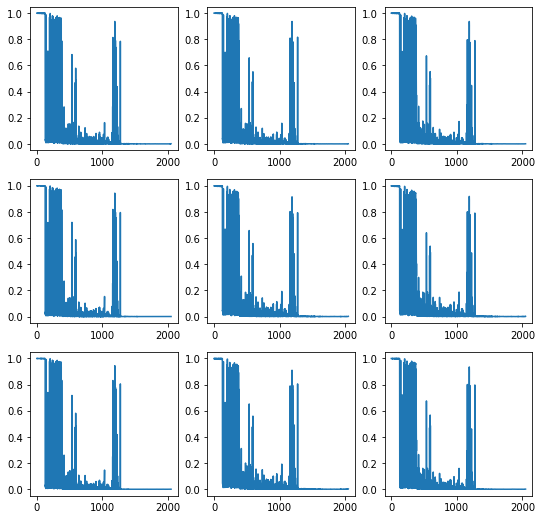

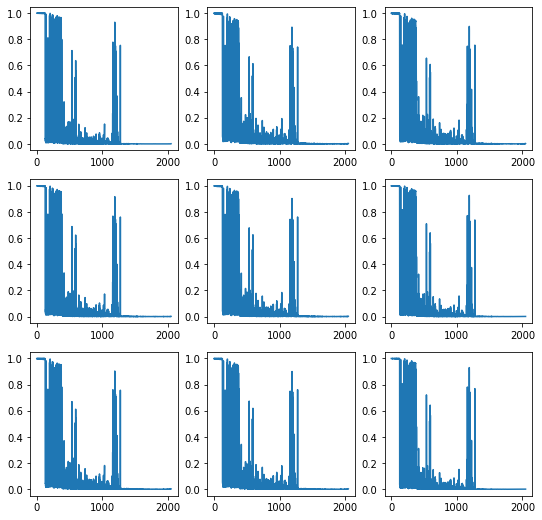

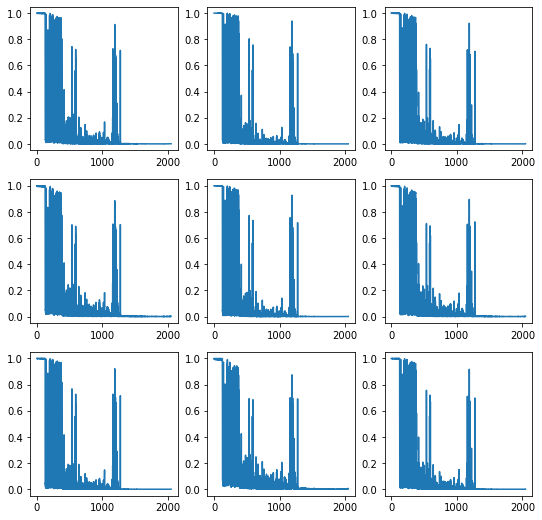

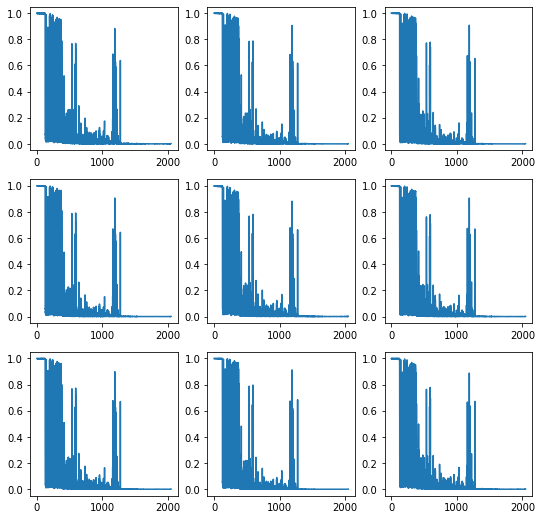

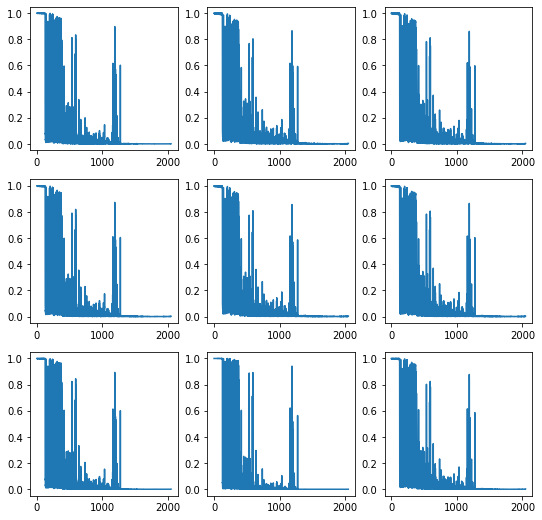

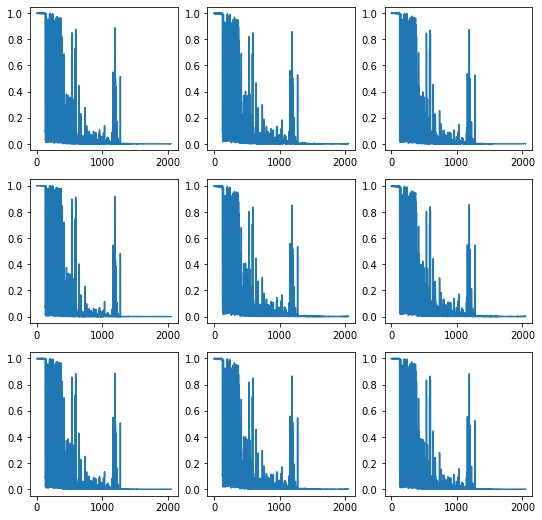

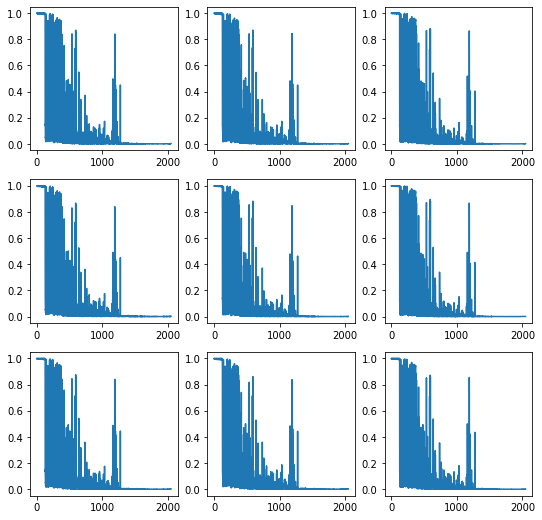

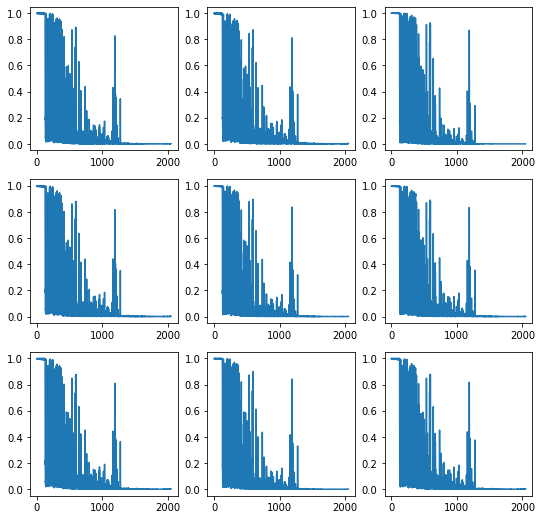

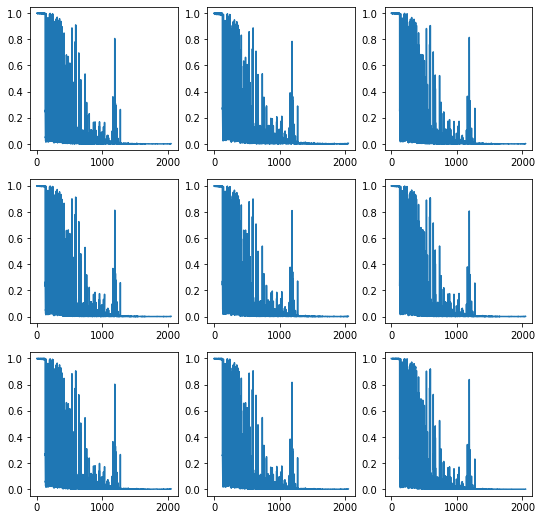

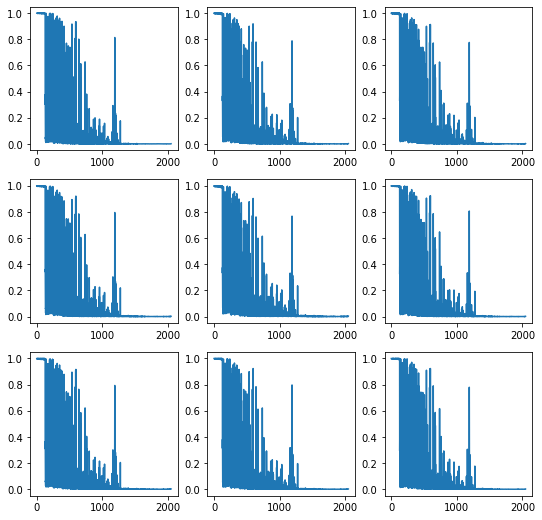

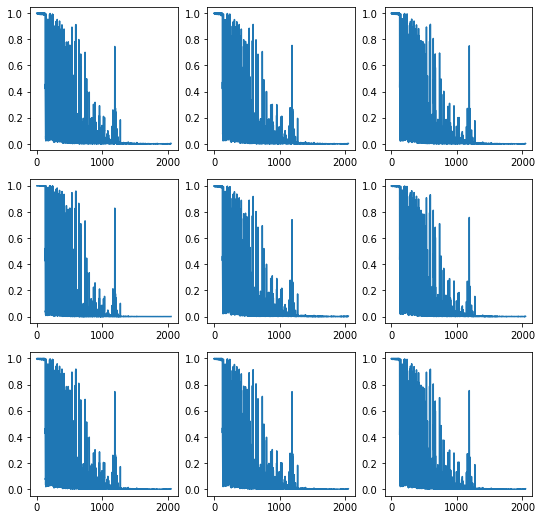

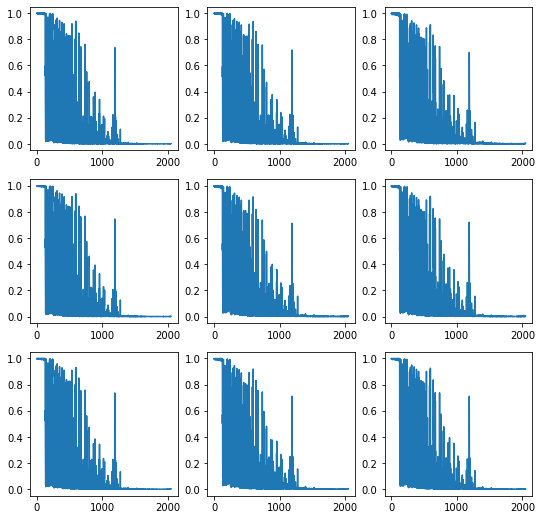

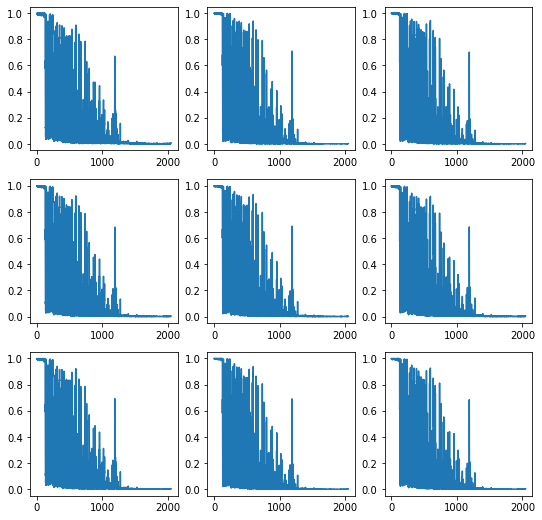

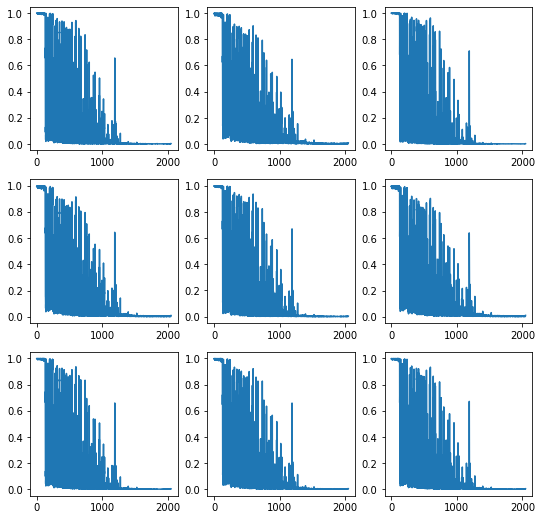

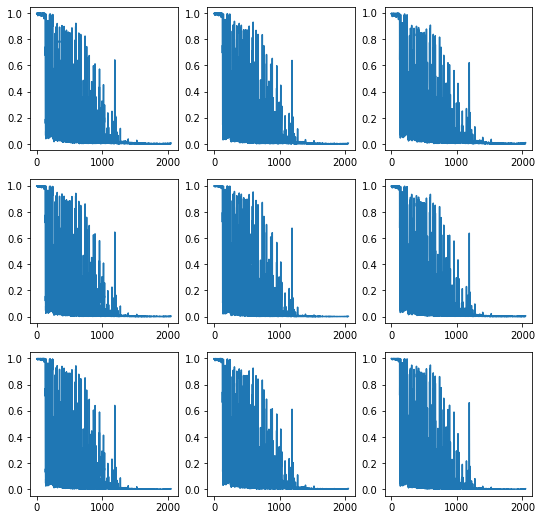

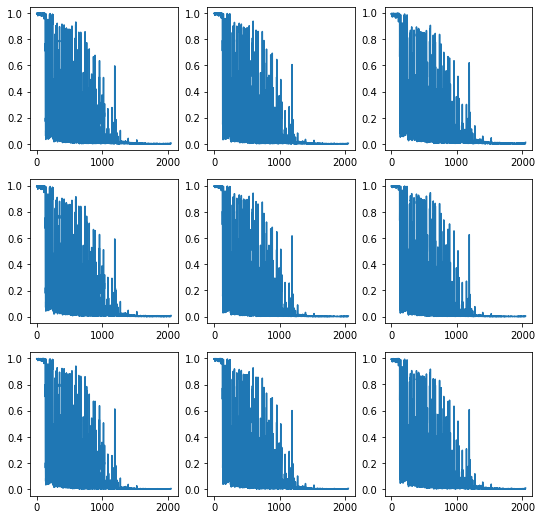

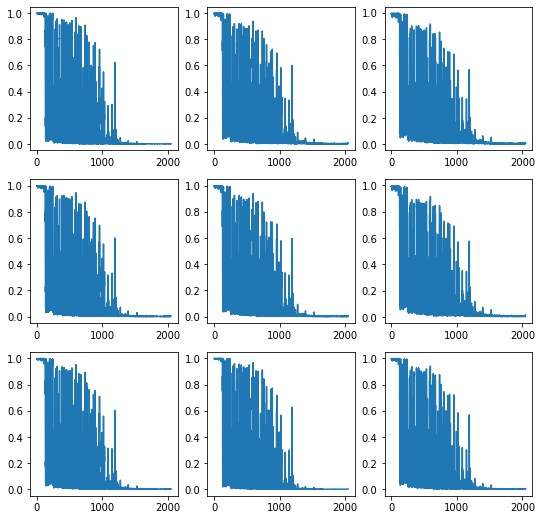

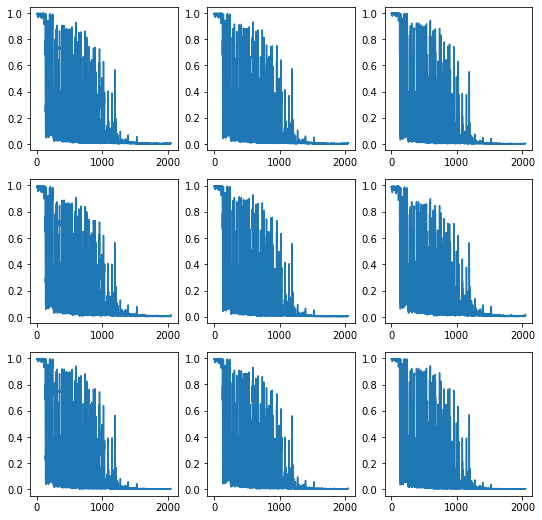

In [ ]:
noises_generator = run_train(noises_dataset, \
          Generator, Discriminator, \
          latent_dim=LATENT_DIM, \
          sample_size=SAMPLE_SIZE, \
          learning_rate=LEARNING_RATE, \
          num_epochs=NUM_EPOCHS, \
          batch_size=BATCH_SIZE, \
          print_each=PRINT_EACH, \
          verbose=VERBOSE, \
          no_save=NO_SAVE, \
          hidden_dim=HIDDEN_DIM, \
          cpu=CPU,)

In [51]:
hidden_dim = 10


fc = nn.Linear(LATENT_DIM, hidden_dim)
lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers=1, batch_first=True)

In [44]:
out = fc(z)
out.shape

torch.Size([32, 50, 10])

In [45]:
out, _ = lstm(out)

In [46]:
out.shape

torch.Size([32, 50, 10])

In [47]:
out.reshape(32, -1)



torch.Size([32, 500])

In [ ]:
class Generator(nn.Module):
    def __init__(self, x_dim, latent_dim=100):
        super(Generator, self).__init__()
        self.x_dim = x_dim
        self.latent_dim = latent_dim
        self.in_channels = 32
        
        self.relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.1)
        self.upsample = nn.Upsample(scale_factor=self.in_channels)
        
        self.fc = nn.Linear(self.latent_dim, self.x_dim + 14)
    
        self.conv1 = nn.Conv1d(self.in_channels, 16, 5)
        self.conv2 = nn.Conv1d(16, 8, 5)
        self.conv3 = nn.Conv1d(8, 4, 5)
        self.conv4 = nn.Conv1d(4, 1, 3)

    def forward(self, z):
        out = self.relu(self.fc(z))
        out = self.upsample(out.unsqueeze(1))
        out = out.view(out.shape[0], self.in_channels, self.x_dim + 14)
        out = self.relu(self.conv1(out))
        out = self.relu(self.conv2(out))
        out = self.relu(self.conv3(out))
        out = self.conv4(out)

        return torch.sigmoid(out.squeeze(1))


class Discriminator(nn.Module):
    def __init__(self, x_dim):
        super(Discriminator, self).__init__()
        self.x_dim = x_dim
        self.in_channels = 16
        
        self.relu = nn.LeakyReLU(0.2)

        self.fc_final = nn.Linear(self.x_dim // self.in_channels - 6, 1)

        self.conv1 = nn.Conv1d(self.in_channels, 8, 3)
        self.conv2 = nn.Conv1d(8, 4, 3)
        self.conv3 = nn.Conv1d(4, 1, 3)

    def forward(self, signal, debug=False):
        def _debug(out):
            if debug:
                print(out.shape)

        _debug(signal)
        out = signal.view(signal.shape[0], self.in_channels, self.x_dim // self.in_channels)
        _debug(out)
        out = self.relu(self.conv1(out))
        _debug(out)
        out = self.relu(self.conv2(out))
        _debug(out)
        out = self.relu(self.conv3(out))
        _debug(out)
        out = out.squeeze(1)
        _debug(out)
        out = self.fc_final(out)
        _debug(out)


        return out

In [ ]:
def get_random_signal(data):
    return data[np.random.choice(range(len(data)))]

def get_closest(signal, data):
    diffs = np.mean((data - signal) ** 2, axis=1)
    return data[np.argmin(diffs)]

def inspect_results(generated, origin, rows_num=3, cols_num=3):
    f, ax = plt.subplots(rows_num, cols_num, figsize=(12, 12))

    for i in range(rows_num * cols_num):
        generated_el = get_random_signal(generated)
        closest_origin = get_closest(generated_el, origin)
        ax[i // rows_num][i % cols_num].plot(generated_el, alpha=0.7)
        ax[i // rows_num][i % cols_num].plot(closest_origin, alpha=0.7)
        ax[i // rows_num][i % cols_num].legend(['Generated', 'Origin'])
    plt.show()

In [ ]:
generated_noises = np.array([generate_new_signal(noises_generator)[0] for i in range(len(data))])
inspect_results(generated_noises, noises)

In [ ]:
generated_noises = noises_scaler.unscale(generated_noises)
inspect_results(generated_noises, noises)

In [ ]:
generated_data = generated_noises + np.mean(data, axis=0)
inspect_results(generated_data, data)